In [1]:
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize

import pymorphy3
import re


import requests
import zipfile

from io import BytesIO

import keras

from keras.utils import get_file

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from keras import layers
from keras.layers import TextVectorization, LeakyReLU, Conv2DTranspose, Embedding, Bidirectional, Reshape, Dense, BatchNormalization, LSTM
from keras.layers import GRU, Conv2D, MaxPooling2D, Flatten, Dropout, MultiHeadAttention, LayerNormalization, Add, StringLookup
from keras import Sequential
from keras.models import save_model, load_model

import tensorflow as tf

import tensorflow_text as tf_text

from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean


In [2]:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


<font size="7">Eng-Ukr Translation</font> 

In [4]:
def remove_punctuation(text):
    punctuation = string.punctuation
    return ''.join([c if c not in punctuation else '' for c in text])


def remove_spaces(text):
    return re.sub(r'\s+', ' ', text)


def clean_text(data):
    cleaned_text = [remove_punctuation(remove_spaces(str(text).lower())) for text in data]
    data = cleaned_text
    return data

In [5]:
def get_text(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    data = requests.get(url, headers=headers)
    data
    print(data)
    datazip = zipfile.ZipFile(BytesIO(data.content))
    text_file = datazip.open("ukr.txt", 'r')
    text = text_file.read()
    text = list(map(chr,text))
    return ''.join(text)

In [6]:
url = "https://www.manythings.org/anki/ukr-eng.zip"

In [7]:
#text = get_text(url) 

In [8]:
text_file = open("ukr-eng.txt", 'r', encoding='utf-8')
text = text_file.read()
num_words = 10000
sequence_length = 100
batch_size = 64

In [9]:
def text_to_data(text):
    lines = text.split("\n")[:-1]
    eng = []
    ukr = []
    for line in lines:
        e, u, att = line.split("\t")
        eng.append(e)
        ukr.append(u)
    eng = clean_text(eng)
    ukr = clean_text(ukr)
    return eng, ukr

In [10]:
eng, ukr = text_to_data(text)
#t_eng = [tf.strings.join(['[START]', text, '[END]'], separator=' ') for text in eng]
#t_ukr = [tf.strings.join(['[START]', text, '[END]'], separator=' ') for text in ukr]

In [11]:
#ukr1 = ["[START] " + u + " [END]" for u in ukr]
print(ukr[50])
#print(t_ukr[50].numpy().decode())

зїж це


In [12]:
punct = string.punctuation
punct.replace('[', '')
punct.replace(']', '')

def standardization(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, "[%s]" % re.escape(punct), "")
    return tf.strings.join(['[START]', text, '[END]'], separator=' ')

In [13]:
eng_vectorization = TextVectorization(max_tokens = num_words, output_mode="int",
                                      standardize=standardization #output_sequence_length=sequence_length
                                     )
ukr_vectorization = TextVectorization(max_tokens = num_words, output_mode="int",
                                      standardize=standardization #output_sequence_length=sequence_length
                                     )

In [14]:
eng_vectorization.adapt(eng)
ukr_vectorization.adapt(ukr)

In [15]:
vocab_ukr = np.array(ukr_vectorization.get_vocabulary())
vocab_eng = np.array(eng_vectorization.get_vocabulary())
print(vocab_ukr[:10])
print(vocab_eng[:10])

['' '[UNK]' '[START]' '[END]' 'я' 'том' 'не' 'що' 'це' 'ти']
['' '[UNK]' '[START]' '[END]' 'tom' 'i' 'you' 'to' 'the' 'a']


In [16]:
def vectorize_text(eng, ukr):
    eng = eng_vectorization(eng)
    ukr = ukr_vectorization(ukr)
    return (eng, ukr)

In [17]:
eng_1, ukr_1 = vectorize_text(eng[500:502], ukr[500:502])

In [18]:
example_translation = vocab_ukr[ukr_1[0].numpy()]
' '.join(example_translation)

'[START] мені болісно [END]'

In [19]:
def process_text(eng, ukr):
    eng = clean_text(eng)
    ukr = clean_text(ukr)
    eng, ukr = vectorize_text(eng, ukr)
    #ukr = ukr .to_tensor()
    dec_output = ukr[:,1:] #.to_tensor()
    enc_input = eng
    dec_input = ukr[:,:-1] #.to_tensor()
    return (enc_input, dec_input), dec_output

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(eng, ukr, train_size=0.6, random_state = 5)

In [21]:
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, train_size=0.5, random_state = 5)

In [22]:
buffer_size = len(eng)
batch_size = 64

In [24]:
train_data = process_text(X_train, Y_train)
test_data = process_text(X_test, Y_test)
val_data = process_text(X_val, Y_val)

In [25]:
eng_vectorization.vocabulary_size()

10000

In [26]:
class Encoder(layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.embed_dim = text_processor.vocabulary_size()
        self.units = units

        self.l_embedding = Embedding(self.embed_dim, units,
                                               mask_zero=True)
        self.l_rnn = Bidirectional(merge_mode='sum',
                                 layer=LSTM(units, 
                                            return_sequences=True)
                                  )
    def call(self, x):
        x = self.l_embedding(x)
        x = self.l_rnn(x)
        return x
    
    def convert_input(self, text):
        if isinstance(text, list):
            text = tf.convert_to_tensor(text)
        if len(text.shape) == 0:
            text = tf.convert_to_tensor(text)[tf.newaxis]
        context = self.text_processor(text)
        context = self(context)
        return context

In [27]:
class CrossAttention(layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.l_attention = MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.l_normalization = LayerNormalization()
        self.l_add = Add()

    def call(self, x, context):

        attn_output, attn_scores = self.l_attention(query=x,
                                            value=context,
                                            return_attention_scores=True
                                           )

        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        self.last_attention_weights = attn_scores

        x = self.l_add([x, attn_output])
        x = self.l_normalization(x)
        return x

In [28]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        
        self.word_to_id = StringLookup(vocabulary=text_processor.get_vocabulary(), 
                                                       mask_token='', oov_token='[UNK]')
        self.id_to_word = StringLookup(vocabulary=text_processor.get_vocabulary(),
                                                       mask_token='', oov_token='[UNK]',invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units

        self.l_embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                   units, mask_zero=True)

        self.l_rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        self.l_attention = CrossAttention(units)

        self.l_dense = Dense(self.vocab_size)
    
    def call(self, context, x, state=None, return_state=False):
        #state = None
        x = self.l_embedding(x)
        x, state = self.l_rnn(x, initial_state = state)
        x = self.l_attention(x, context)
        self.last_attention_weights = self.l_attention.last_attention_weights
        logits = self.l_dense(x)
        if return_state:
            return logits, state
        else:
            return logits
        
    def get_initial_state(self, context):
        batch_size = tf.shape(context)[0]
        start_tokens = tf.fill([batch_size, 1], self.start_token)  
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        embedded = self.l_embedding(start_tokens)
        return start_tokens, done, self.l_rnn.get_initial_state(embedded)[0]
    
    def to_text(self, tokens):
        text = tf.strings.reduce_join(self.id_to_word(tokens), axis=-1, separator=' ')
        text = tf.strings.regex_replace(text, '^ *\[START\] *', '')
        text = tf.strings.regex_replace(text, ' *\[END\] *$', '')
        return text
    
    def get_next_token(self, context, next_token, done, state, temperature = 0.0):
        logits, state = self(
            context, next_token,
            state = state,
            return_state=True) 
        if temperature == 0.0:
            next_token = tf.argmax(logits, axis=-1)
        else:
            logits = logits[:, -1, :]/temperature
            next_token = tf.random.categorical(logits, num_samples=1)
        if temperature == 0.0:
            next_token = tf.argmax(logits, axis=-1)
        else:
            logits = logits[:, -1, :]/temperature
            next_token = tf.random.categorical(logits, num_samples=1)
        done = done | (next_token == self.end_token)
        next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
        
        return next_token, done, state
    
        
        

In [29]:
class TranslatorModel(keras.Model):
    def __init__(self, units, context_vectorization, target_vectorization):
        super().__init__() 
        self.encoder = Encoder(context_vectorization, units)
        self.decoder = Decoder(target_vectorization, units)
        
    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)
        return logits
    
    def translate(self,
                  text, *,
                  max_length=50,
                  temperature=0.0):
        context = self.encoder.convert_input(text)
        batch_size = tf.shape(text)[0]

        tokens = []
        attention_weights = []
        next_token, done, state = self.decoder.get_initial_state(context)

        for n in range(max_length):
            next_token, done, state = self.decoder.get_next_token(context, next_token, done,  state, temperature)
            tokens.append(next_token)
            attention_weights.append(self.decoder.last_attention_weights)
            if tf.executing_eagerly() and tf.reduce_all(done):
                break
        tokens = tf.concat(tokens, axis=-1)  
        self.last_attention_weights = tf.concat(attention_weights, axis=1)  
        result = self.decoder.to_text(tokens)
        return result

In [30]:
def masked_loss(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [31]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [32]:
units = 128

In [33]:
translator = TranslatorModel(units, eng_vectorization, ukr_vectorization)

translator.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])


In [36]:
history = translator.fit(
    train_data[0], train_data[1], 
    epochs=40,
    validation_data=(val_data[0], val_data[1]),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
        )

Epoch 1/40
2929/2929 [==============================] - 395s 126ms/step - loss: 0.8299 - masked_acc: 0.4957 - masked_loss: 3.1754 - val_loss: 0.5395 - val_masked_acc: 0.6095 - val_masked_loss: 2.0631
Epoch 2/40
2929/2929 [==============================] - 319s 109ms/step - loss: 0.4141 - masked_acc: 0.6625 - masked_loss: 1.5845 - val_loss: 0.4150 - val_masked_acc: 0.6658 - val_masked_loss: 1.5869
Epoch 3/40
2929/2929 [==============================] - 322s 110ms/step - loss: 0.3021 - masked_acc: 0.7190 - masked_loss: 1.1561 - val_loss: 0.3817 - val_masked_acc: 0.6854 - val_masked_loss: 1.4598
Epoch 4/40
2929/2929 [==============================] - 393s 134ms/step - loss: 0.2472 - masked_acc: 0.7544 - masked_loss: 0.9457 - val_loss: 0.3700 - val_masked_acc: 0.6987 - val_masked_loss: 1.4149
Epoch 5/40
2929/2929 [==============================] - 365s 125ms/step - loss: 0.2123 - masked_acc: 0.7796 - masked_loss: 0.8125 - val_loss: 0.3667 - val_masked_acc: 0.7005 - val_masked_loss: 1.4025


In [43]:
translator.summary()

Model: "translator_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  1543168   
                                                                 
 decoder (Decoder)           multiple                  2735376   
                                                                 
Total params: 4,278,544
Trainable params: 4,278,544
Non-trainable params: 0
_________________________________________________________________


In [39]:
translator.evaluate(test_data[0],test_data[1])

977/977 [==============================] - 79s 73ms/step - loss: 0.2771 - masked_acc: 0.7118 - masked_loss: 1.4269


[0.2770528793334961, 0.7117617130279541, 1.4268622398376465]

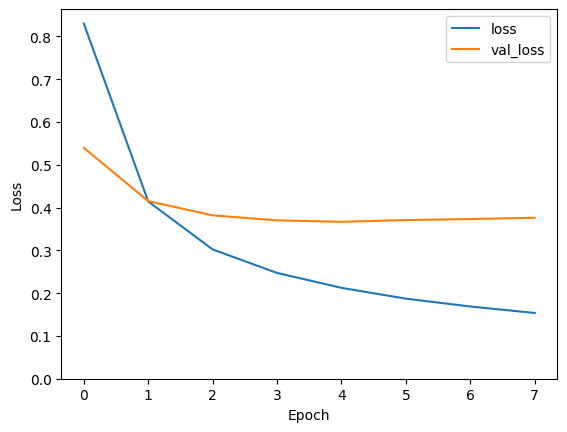

In [41]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

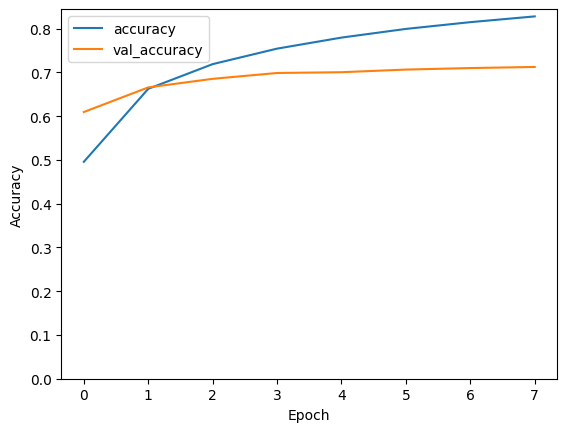

In [42]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [44]:
history = translator.fit(
    train_data[0], train_data[1], 
    epochs=10,
    validation_data=(val_data[0], val_data[1]),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
        )

Epoch 1/10
2929/2929 [==============================] - 339s 116ms/step - loss: 0.1409 - masked_acc: 0.8402 - masked_loss: 0.5391 - val_loss: 0.3817 - val_masked_acc: 0.7137 - val_masked_loss: 1.4595
Epoch 2/10
2929/2929 [==============================] - 326s 111ms/step - loss: 0.1307 - masked_acc: 0.8493 - masked_loss: 0.5000 - val_loss: 0.3901 - val_masked_acc: 0.7150 - val_masked_loss: 1.4917
Epoch 3/10
2929/2929 [==============================] - 316s 108ms/step - loss: 0.1217 - masked_acc: 0.8580 - masked_loss: 0.4658 - val_loss: 0.3938 - val_masked_acc: 0.7120 - val_masked_loss: 1.5061
Epoch 4/10
2929/2929 [==============================] - 327s 112ms/step - loss: 0.1144 - masked_acc: 0.8646 - masked_loss: 0.4378 - val_loss: 0.4005 - val_masked_acc: 0.7147 - val_masked_loss: 1.5315


In [37]:
translator.evaluate(test_data[0], test_data[1])

977/977 [==============================] - 86s 72ms/step - loss: 0.2940 - masked_acc: 0.7160 - masked_loss: 1.5143


[0.2940286695957184, 0.716044008731842, 1.5142885446548462]

In [35]:
history = translator.fit(
    train_data[0], train_data[1], 
    epochs=3,
    validation_data=(val_data[0], val_data[1]))

Epoch 1/3
2929/2929 [==============================] - 369s 114ms/step - loss: 0.1079 - masked_acc: 0.8713 - masked_loss: 0.4128 - val_loss: 0.4127 - val_masked_acc: 0.7161 - val_masked_loss: 1.5782
Epoch 2/3
2929/2929 [==============================] - 343s 117ms/step - loss: 0.1023 - masked_acc: 0.8764 - masked_loss: 0.3915 - val_loss: 0.4129 - val_masked_acc: 0.7176 - val_masked_loss: 1.5789
Epoch 3/3
2929/2929 [==============================] - 365s 125ms/step - loss: 0.0971 - masked_acc: 0.8818 - masked_loss: 0.3714 - val_loss: 0.4194 - val_masked_acc: 0.7167 - val_masked_loss: 1.6039


In [36]:
translator.evaluate(test_data[0], test_data[1])

977/977 [==============================] - 92s 86ms/step - loss: 0.3096 - masked_acc: 0.7164 - masked_loss: 1.5942


[0.3095504641532898, 0.7163591384887695, 1.5942269563674927]

In [37]:
translator.save_weights("saved_model\\" + 'tmodel')

In [34]:
translator.load_weights("saved_model\\" + 'tmodel')

In [45]:
text = ["i was here today", "hello my name is Tom", "good morning", "four carrots"]
print(translator.translate(text)[0].numpy().decode())
print(translator.translate(text)[1].numpy().decode())
print(translator.translate(text)[2].numpy().decode())
print(translator.translate(text)[3].numpy().decode())

я був тут сьогодні 
привіт моє імя том 
доброго ранку   
чотири моркву   


In [37]:
train_data[0][0].shape

TensorShape([93703, 29])

<font size="7">Image Generation</font> 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

import os, sys

import requests
import keras

from keras.utils import get_file

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from keras import layers
from keras.layers import TextVectorization, LeakyReLU, Conv2DTranspose, Embedding, Bidirectional, Reshape, Dense, BatchNormalization, LSTM
from keras.layers import GRU, Conv2D, MaxPooling2D, Flatten, UpSampling2D, Dropout, MultiHeadAttention, LayerNormalization, Add, StringLookup
from keras import Sequential
from keras.models import save_model, load_model

import tensorflow as tf

import tensorflow_text as tf_text

from skimage import color
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

In [2]:
def load_images():
    x = []
    for i in range(1,711):
        if(i!=201):
            image = io.imread("pokemon\\" + str(i) + ".png")
            image = color.rgba2rgb(image)
            pad = np.full((40,40, 3), (1,1,1), dtype=np.float32)
            x_center = 0
            y_center = (10) // 2
            pad[y_center:y_center+30, x_center:x_center+40] = image
            pad = (pad - 1)*2
            x.append(pad)
    #x = np.asarray(x).astype(np.float32)
    return x

In [3]:
X_train = load_images()
X_train=np.asarray(X_train)
print(X_train.shape)

(709, 40, 40, 3)


In [4]:
#print(X_train[0])

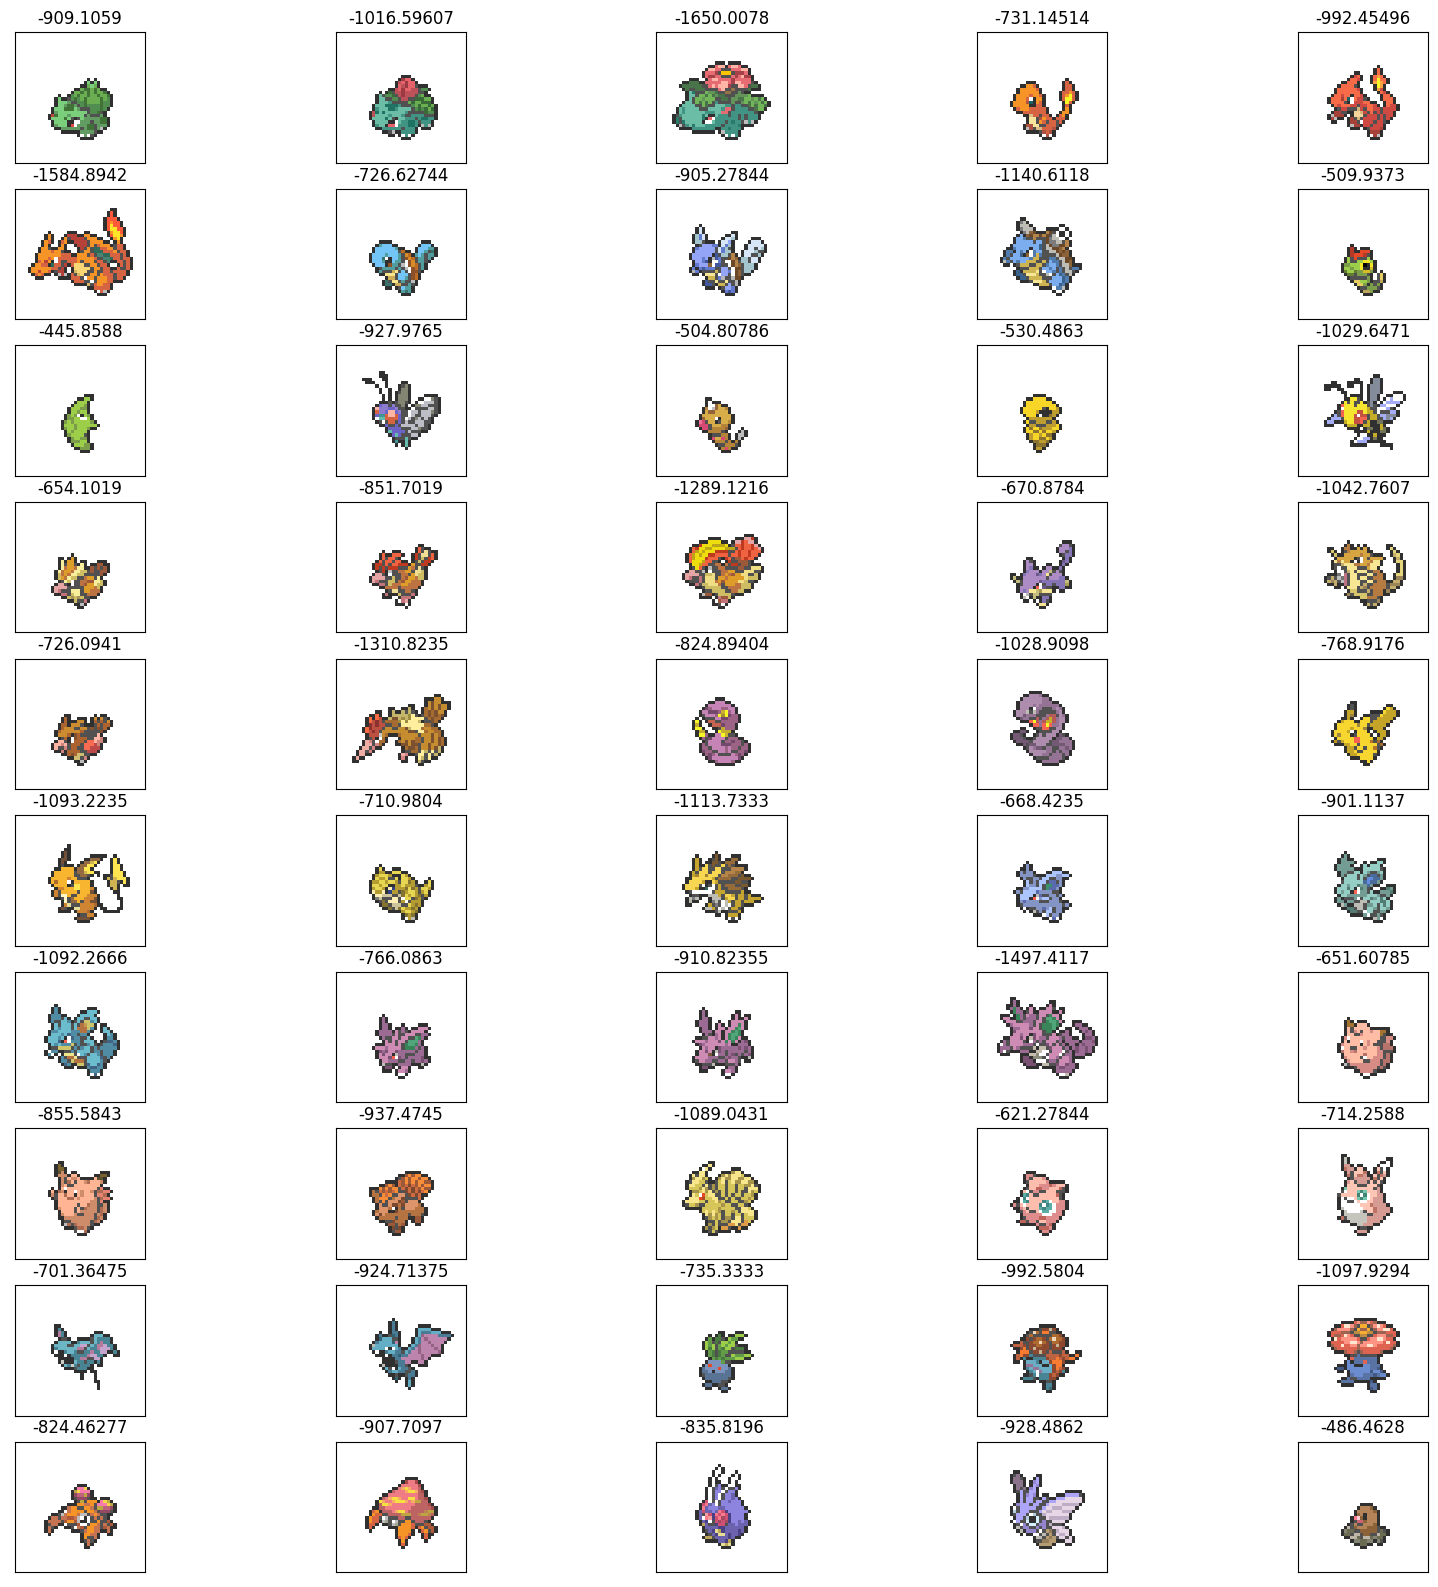

In [5]:
fig = plt.figure(figsize=(20,20))
for row in range(10):
    for column in range(5):
        i = row * 5 + column
        if i>len(X_train)-1:
            break                   
        ax = fig.add_subplot(10, 5, i+1)
        ax.set_title(str(np.sum(X_train[i])))     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(X_train[i]/2 + 1)

In [6]:
optimiz = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimiz_g = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
latent_dim = 100

In [7]:

X_train = np.clip(X_train, -1, 1)

In [8]:
def build_discriminator(optimiz):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", input_shape=(40, 40, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimiz, metrics=['accuracy'])
    return model

In [9]:
def build_generator():
    model = Sequential()
    # foundation for 5x5 image
    n_nodes = 256 * 5 * 5
    model.add(Dense(n_nodes, input_dim=latent_dim))
    
    #model.add(BatchNormalization())
    #model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((5, 5, 256)))
    
    #model.add(Dropout(0.35))
    
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(UpSampling2D())
    model.add(Conv2D(128, 3, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(BatchNormalization())
    
    #model.add(UpSampling2D())
    #model.add(Conv2D(128, 3, padding='same'))
    #model.add(LeakyReLU(alpha=0.2))
    
    
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    #model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model   

In [10]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=optimiz_g)
    return model

In [11]:
def plot_generated_images(generator):
    num_of_images = 6
    noise = np.random.normal(0, 1.0, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise)
    generated_images = np.asarray((generated_images+1)/2.0)
    all_images.append(generated_images)
    plt.figure(figsize=(20, 4))
    for i in range(num_of_images):
        plt.subplot(1, 6, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [12]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [13]:
def train_model(epochs, batch_size):
    size = batch_size
    num_batches = int(X_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        with HiddenPrints():
            for i in range(num_batches):
                #noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_dim])
                noise = np.random.normal(0, 1.0, size=[batch_size, latent_dim])
                image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
                generated_images = generator.predict(noise)    
                X = np.concatenate([image_batch, generated_images])
                y_dis = np.zeros(2*batch_size)
                y_dis[:size] = 0.90 
                y_dis += np.random.uniform(0, 0.1, size = len(y_dis))
                discriminator.trainable = True
                d_loss, _ = discriminator.train_on_batch(X, y_dis)
                discrim_losses.append(d_loss)

                noise = np.random.normal(0, 1.0, size=[batch_size, latent_dim])
                y_gen = np.ones(size) 
                discriminator.trainable = False
                gan.train_on_batch(noise, y_gen)
        if ep % 10 == 0:
            print("epoch: " + str(ep))
            plot_generated_images(generator)
            tf.keras.backend.clear_session()    

In [14]:
discrim_losses = []
acc = []
all_images = []

In [15]:
tf.keras.backend.clear_session()
tf.config.experimental.get_memory_info('GPU:0')['current']

0

In [16]:

generator = build_generator()

1/1 [==============================] - 3s 3s/step


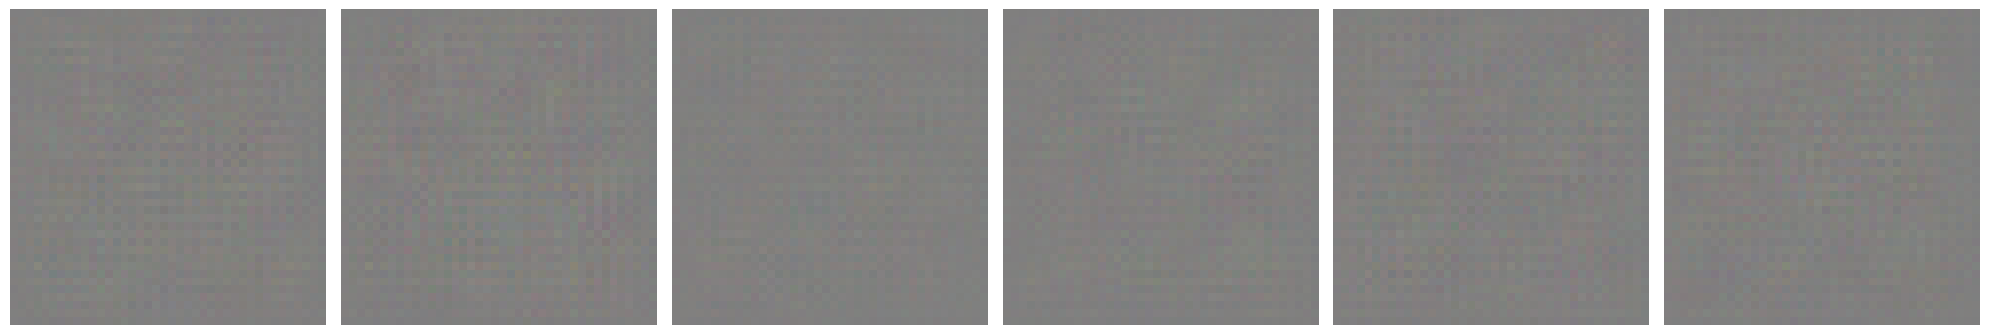

In [17]:
plot_generated_images(generator)

In [17]:
discriminator = build_discriminator(optimiz)
discriminator.summary()
generator.summary()
gan = build_gan(generator, discriminator)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 40, 40, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 40, 40, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 40, 128)       73856     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 40, 40, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 128)       147584    
                                                      

epoch: 0
1/1 [==============================] - 0s 35ms/step


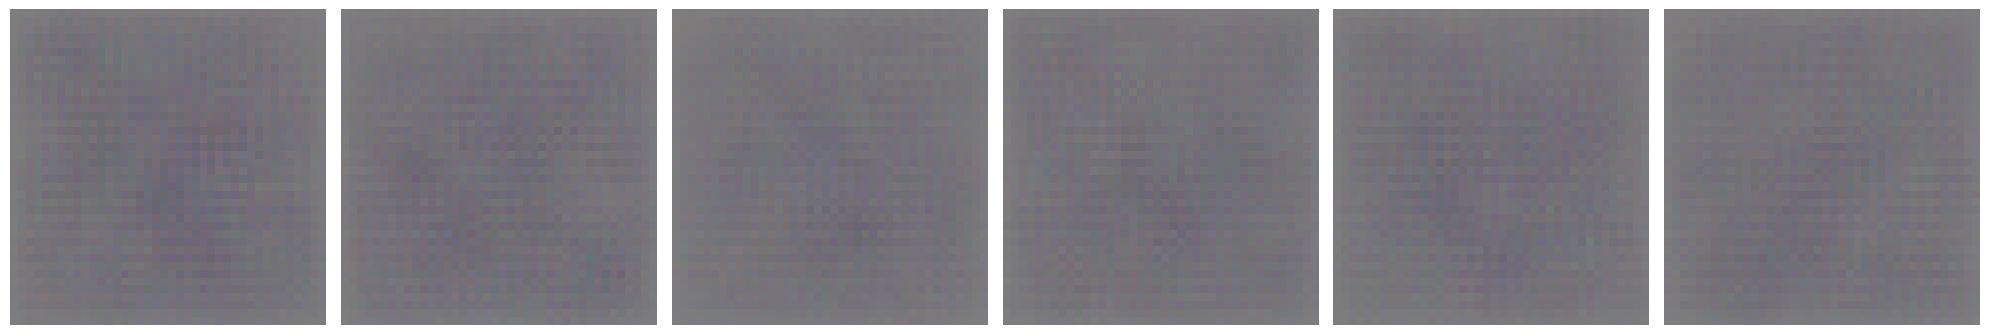

epoch: 10
1/1 [==============================] - 0s 41ms/step


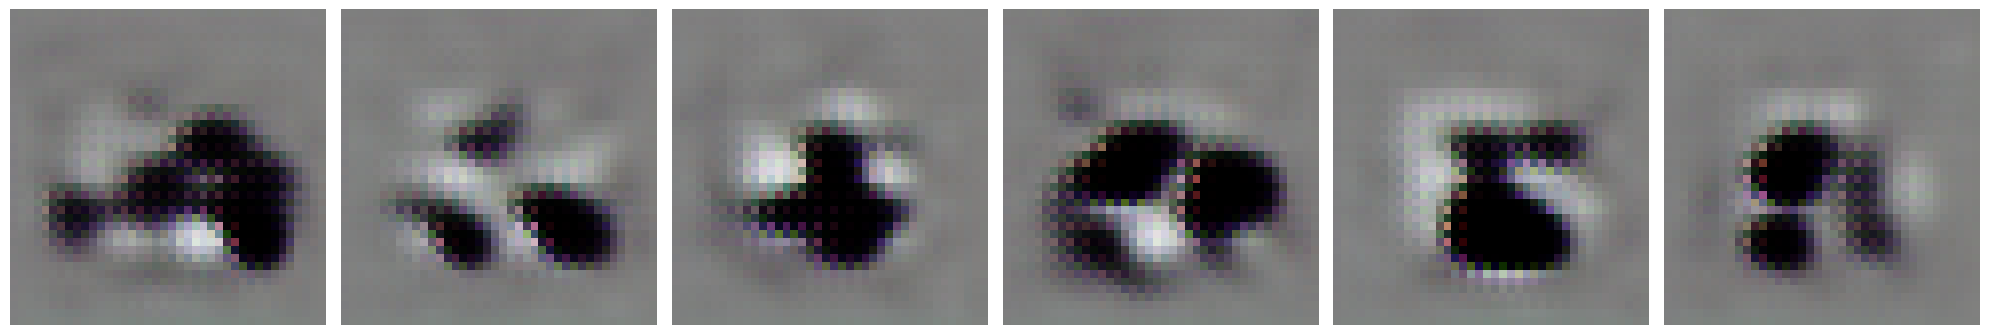

epoch: 20
1/1 [==============================] - 0s 36ms/step


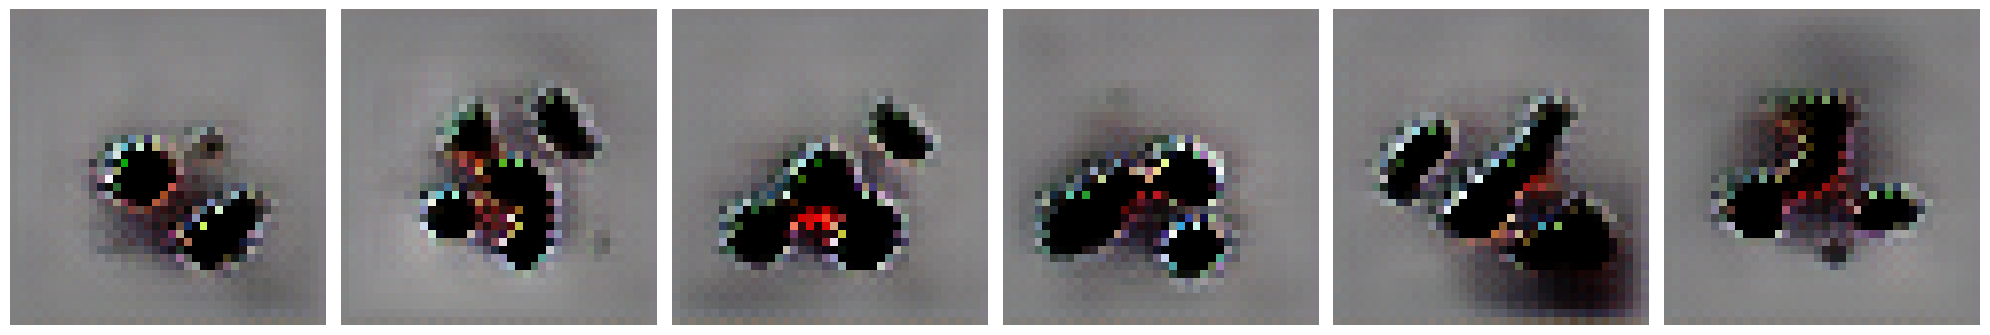

epoch: 30
1/1 [==============================] - 0s 37ms/step


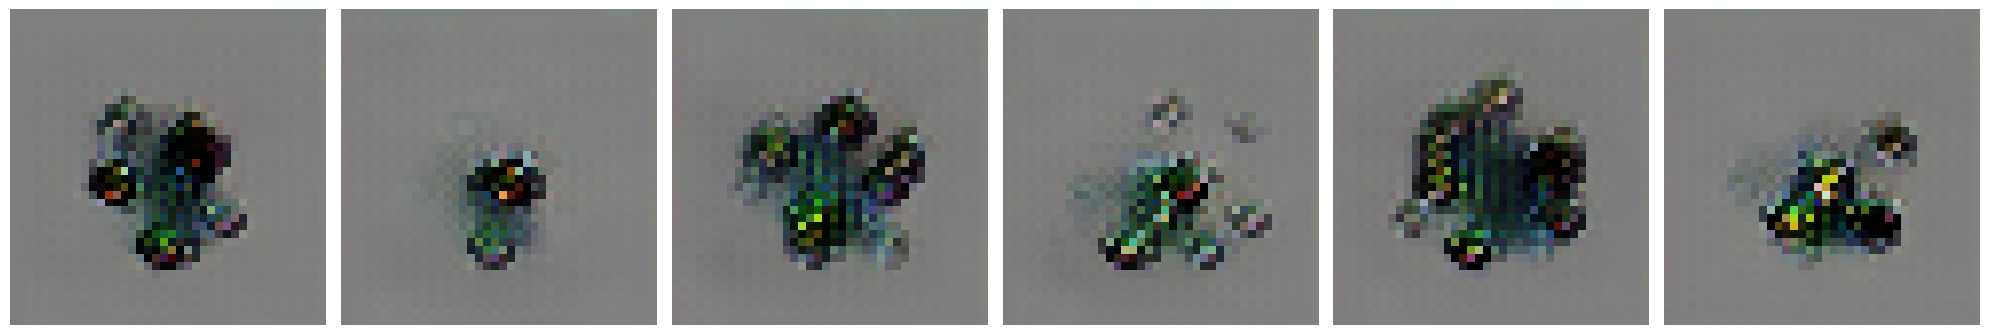

epoch: 40
1/1 [==============================] - 0s 38ms/step


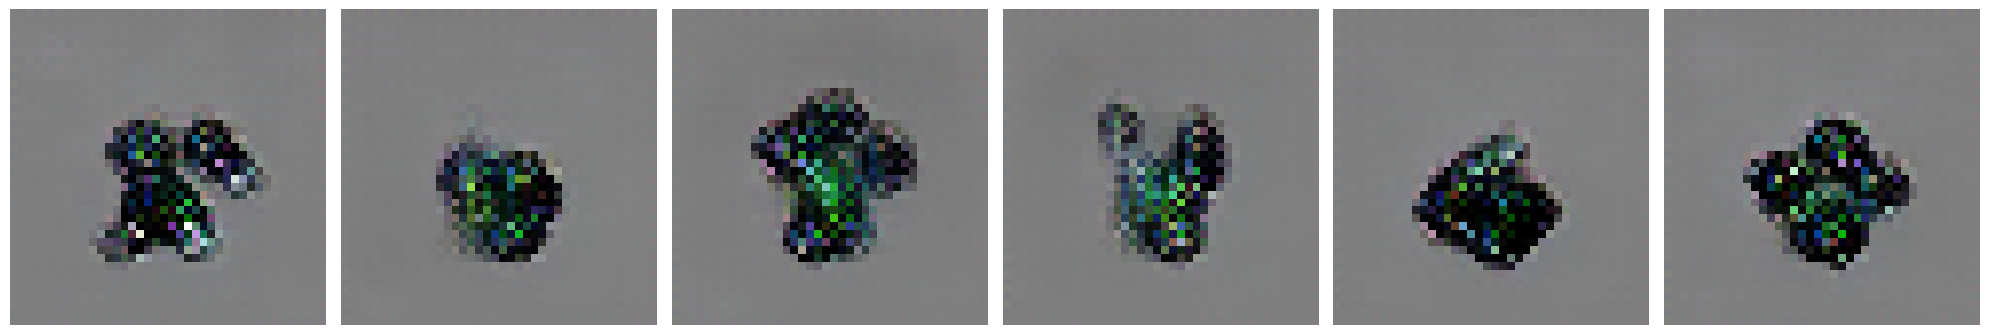

epoch: 50
1/1 [==============================] - 0s 37ms/step


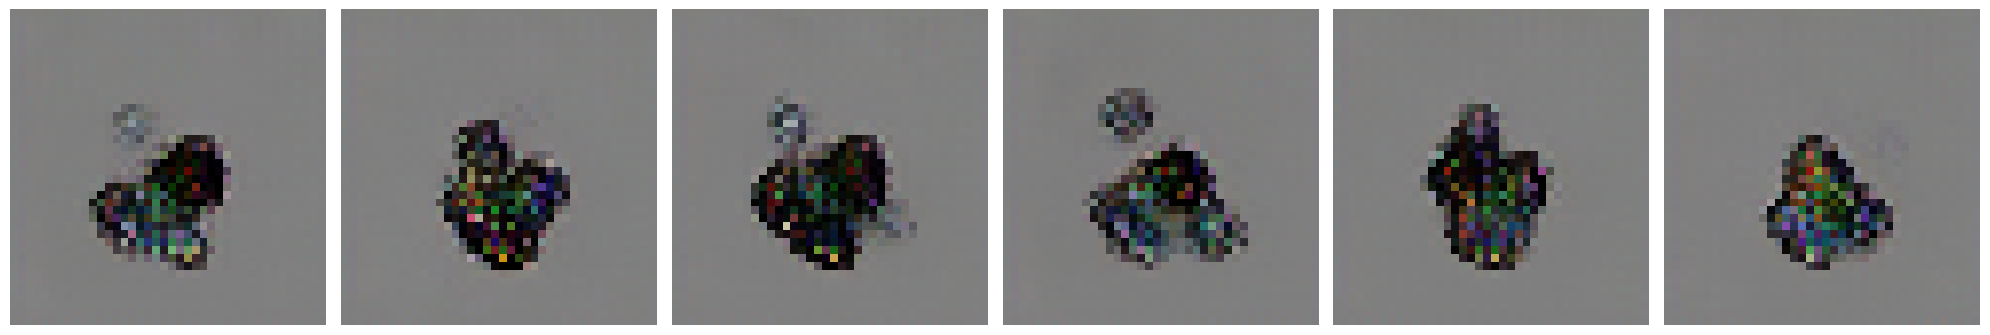

epoch: 60
1/1 [==============================] - 0s 37ms/step


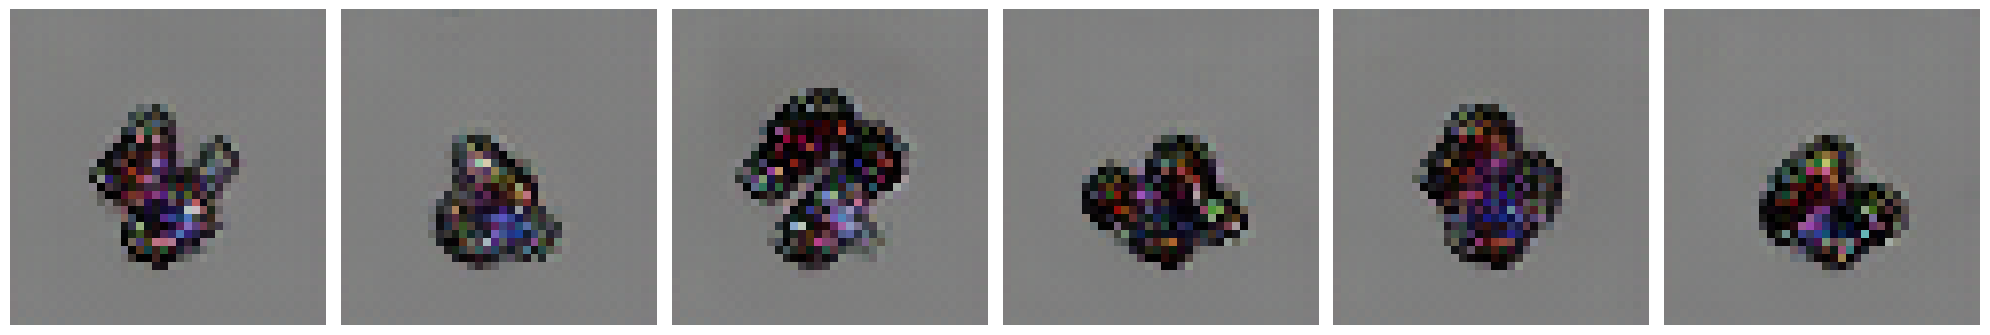

epoch: 70
1/1 [==============================] - 0s 36ms/step


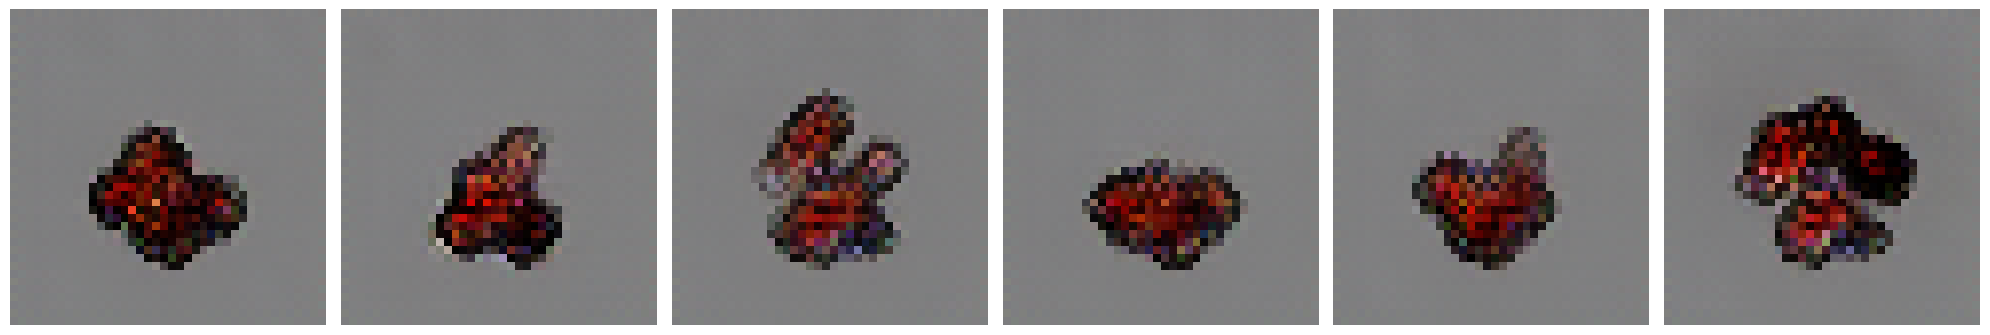

In [19]:

np.random.seed(1)
epochs = 70 # to get good quality images, you should train the model for more than 100 epochs
batch_size = 32
train_model(epochs, batch_size)

In [20]:
gan.save_weights("saved_model\\" + 'pokemodel')

In [45]:
gan.load_weights("saved_model\\" + 'pokemodel')

1/1 [==============================] - 0s 47ms/step


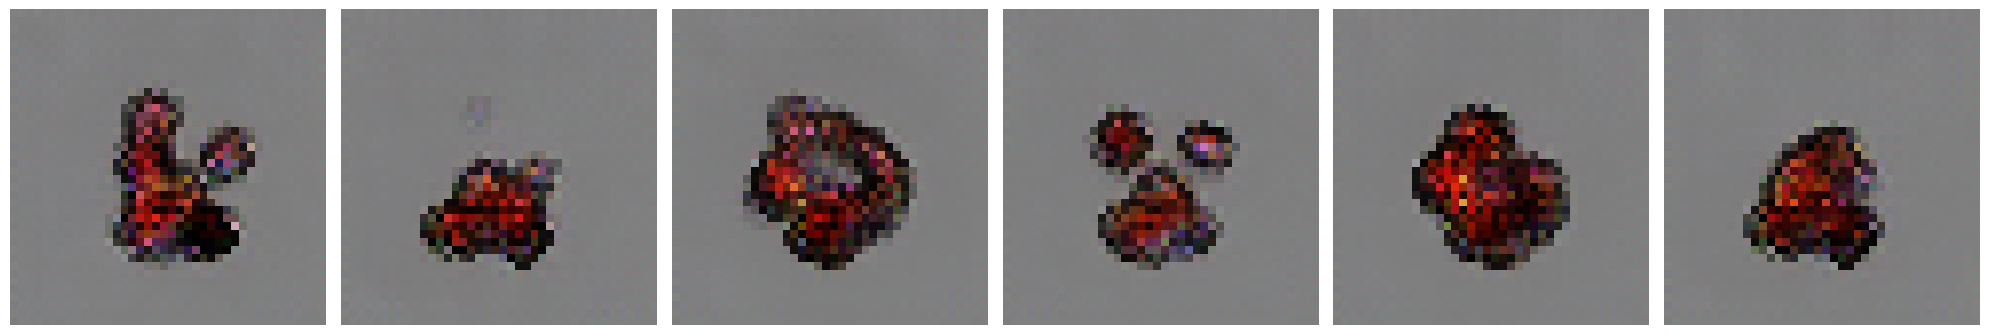

In [49]:
plot_generated_images(generator)

epoch: 0
1/1 [==============================] - 0s 37ms/step


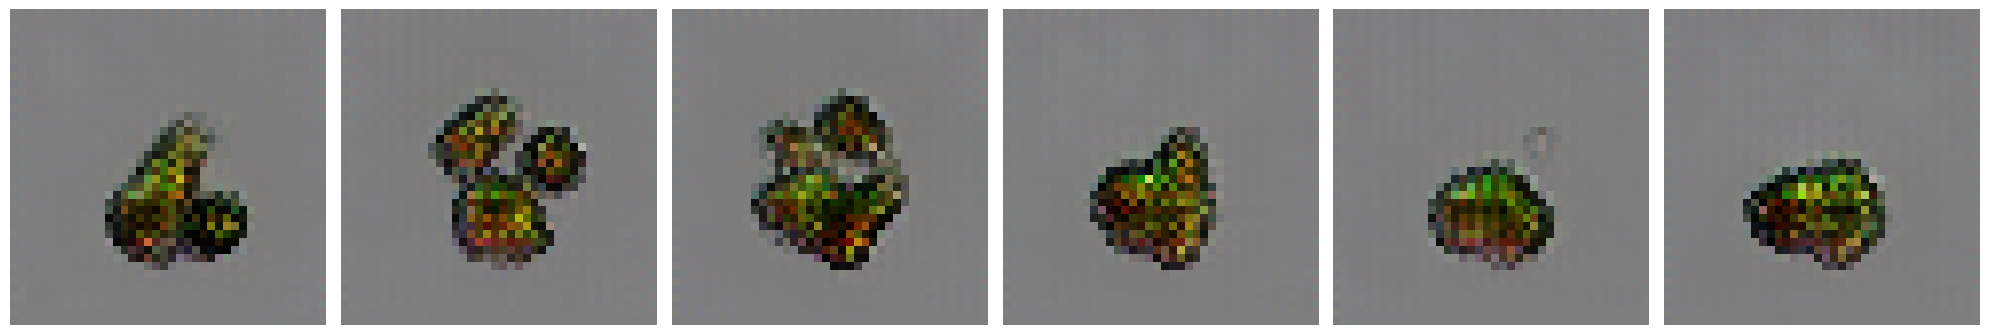

epoch: 10
1/1 [==============================] - 0s 36ms/step


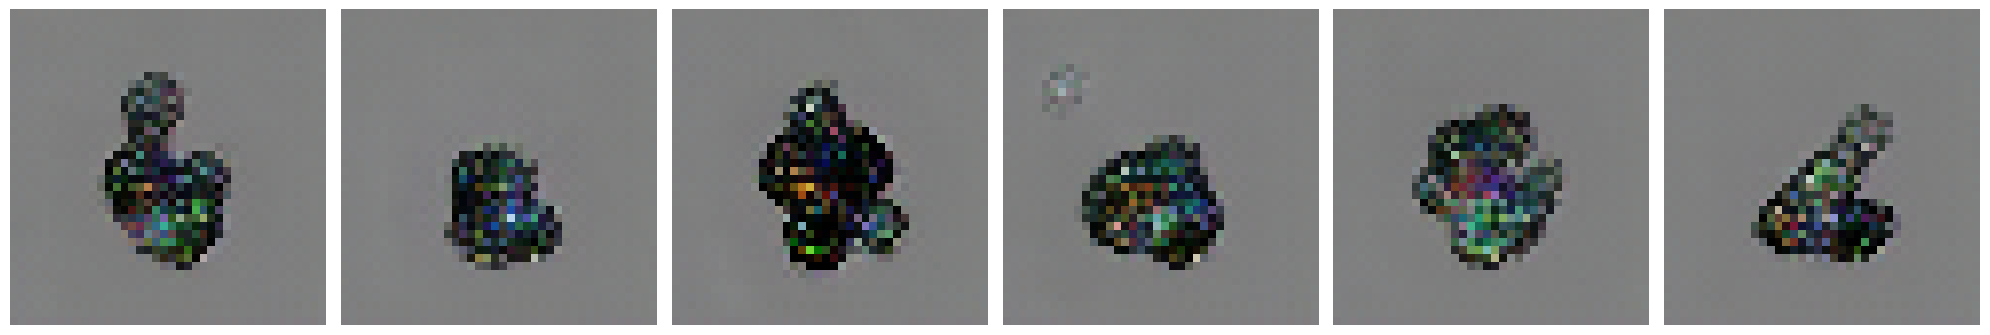

epoch: 20
1/1 [==============================] - 0s 39ms/step


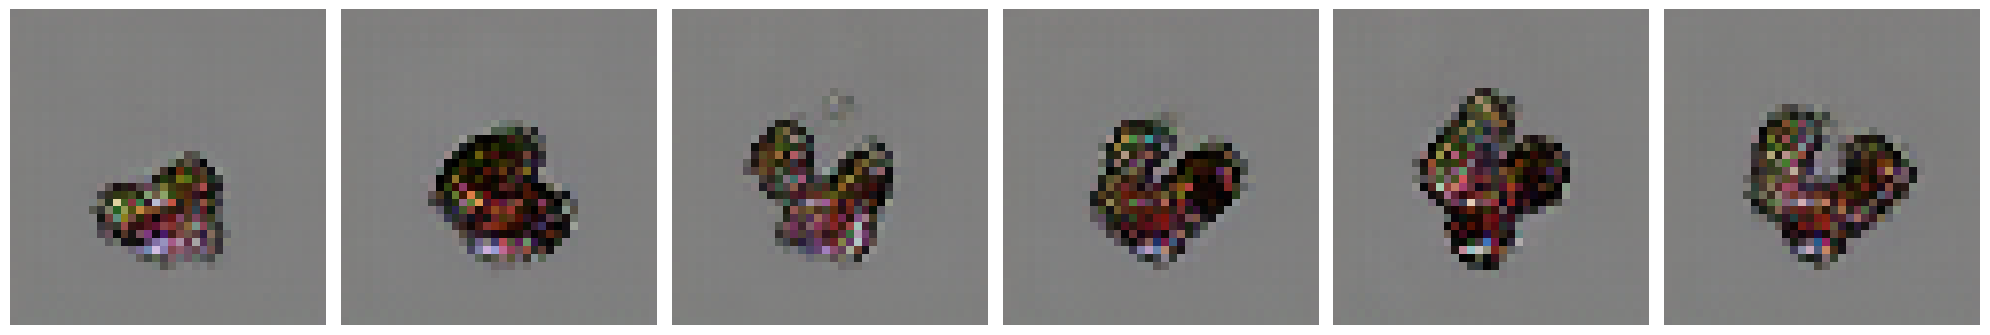

epoch: 30
1/1 [==============================] - 0s 37ms/step


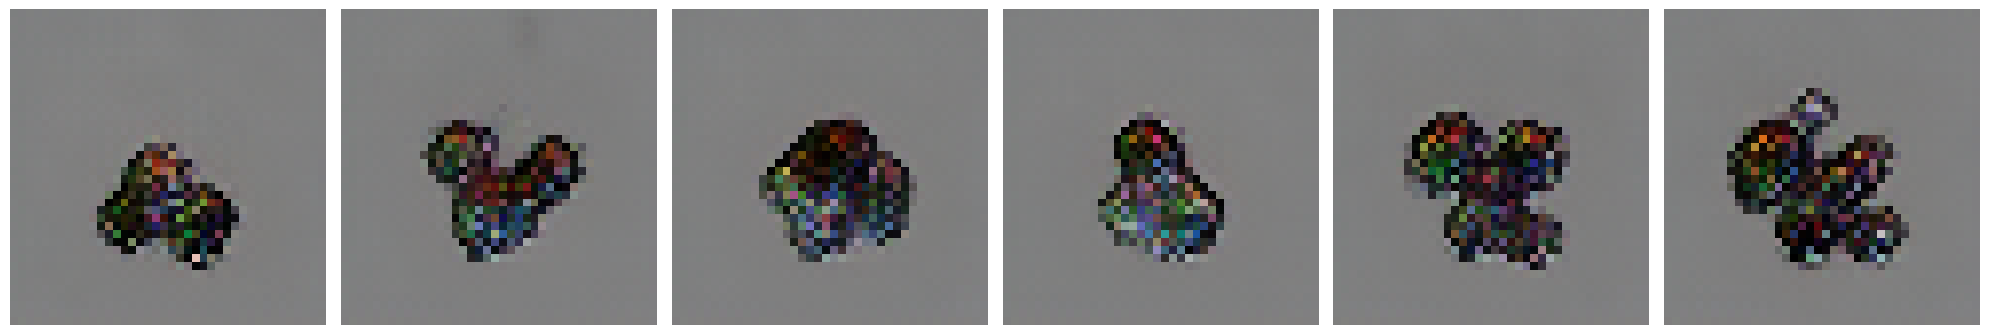

In [38]:
epochs = 30
train_model(epochs, batch_size)

In [44]:
gan.save_weights("saved_model\\" + 'poke2model')

In [ ]:
gan.load_weights("saved_model\\" + 'poke2model')

1/1 [==============================] - 0s 55ms/step


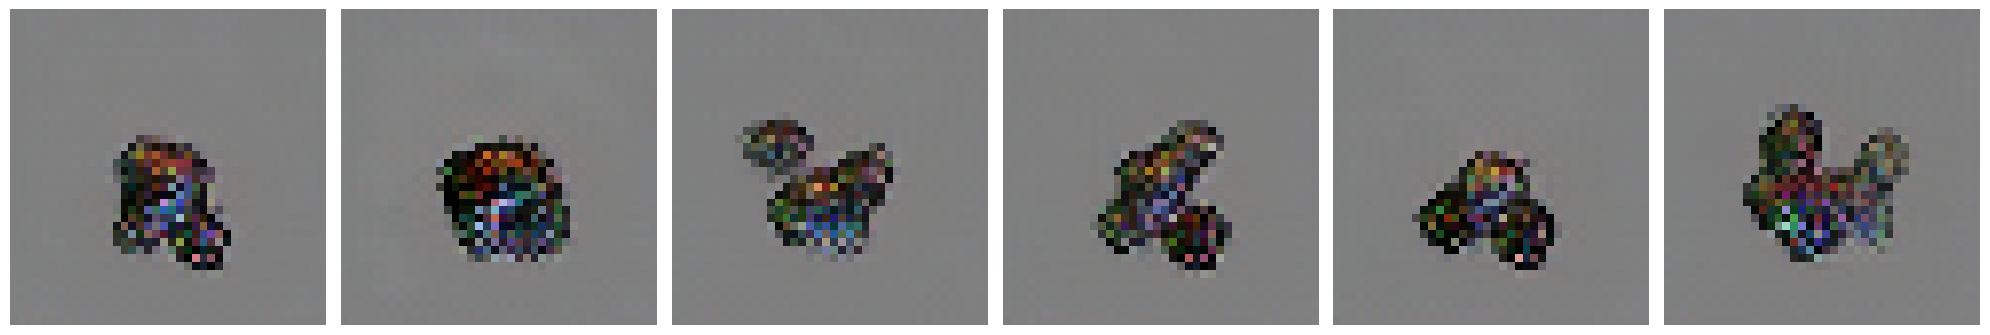

In [43]:
plot_generated_images(generator)

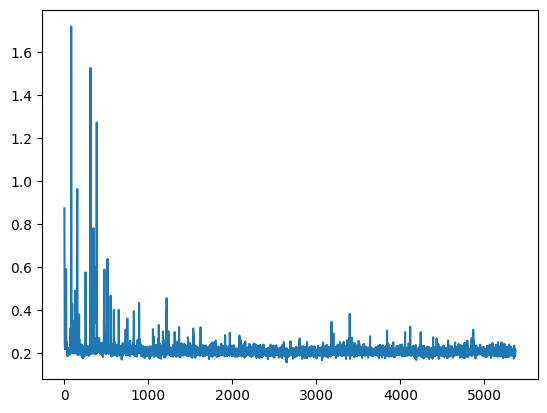

In [50]:
plt.plot(discrim_losses)

epoch: 0
1/1 [==============================] - 0s 35ms/step


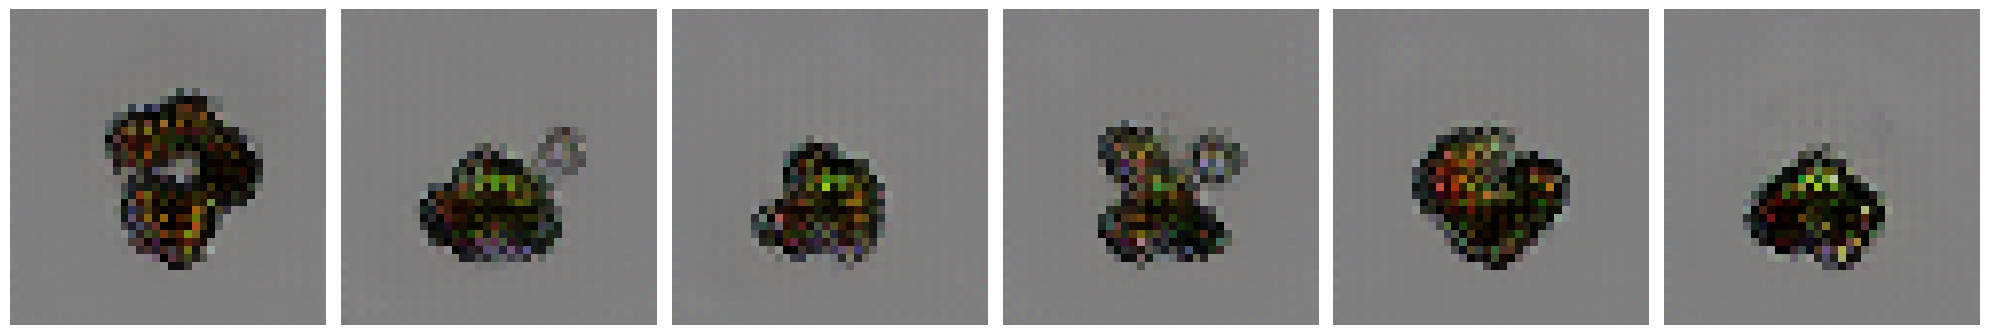

epoch: 10
1/1 [==============================] - 0s 37ms/step


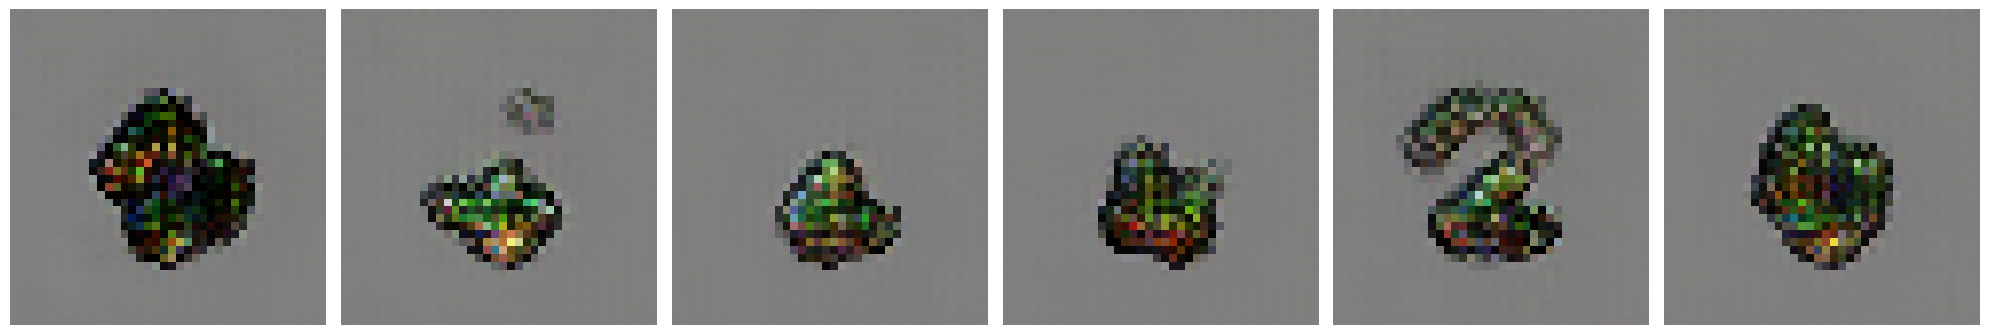

epoch: 20
1/1 [==============================] - 0s 37ms/step


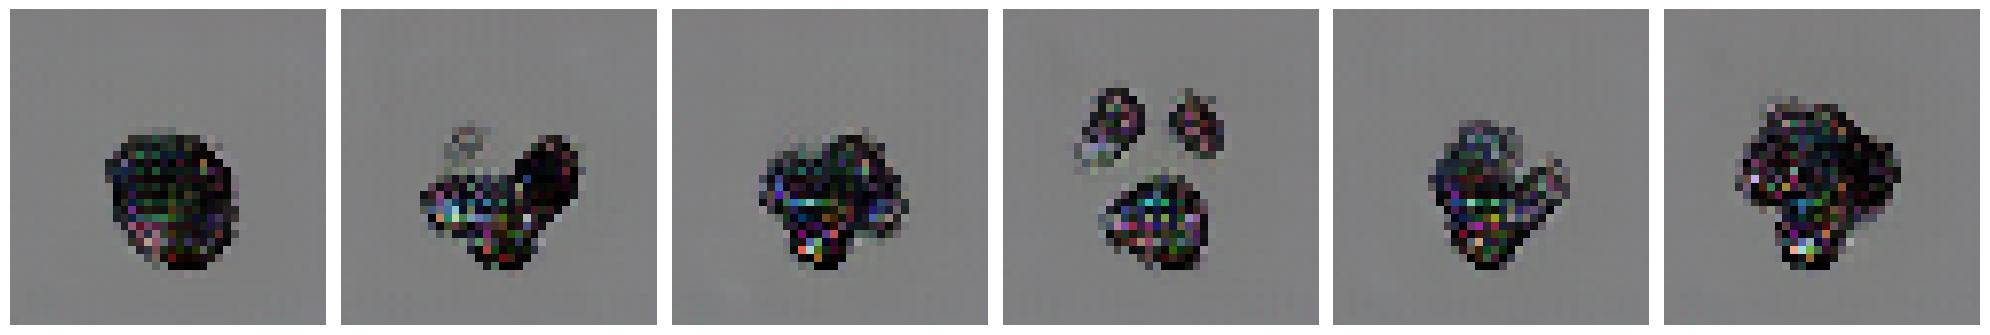

epoch: 30
1/1 [==============================] - 0s 37ms/step


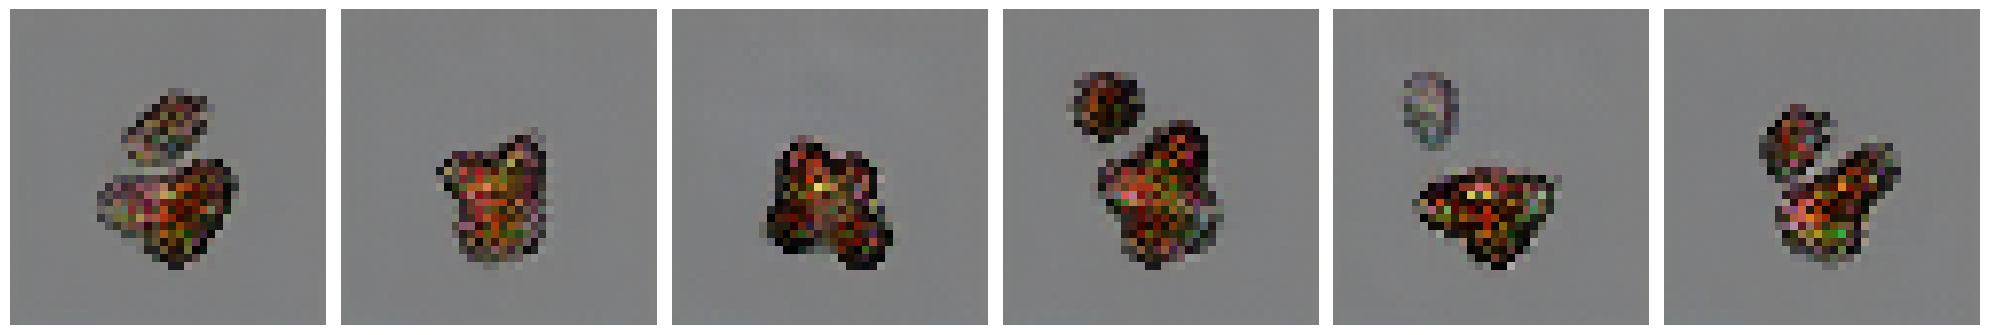

epoch: 40
1/1 [==============================] - 0s 38ms/step


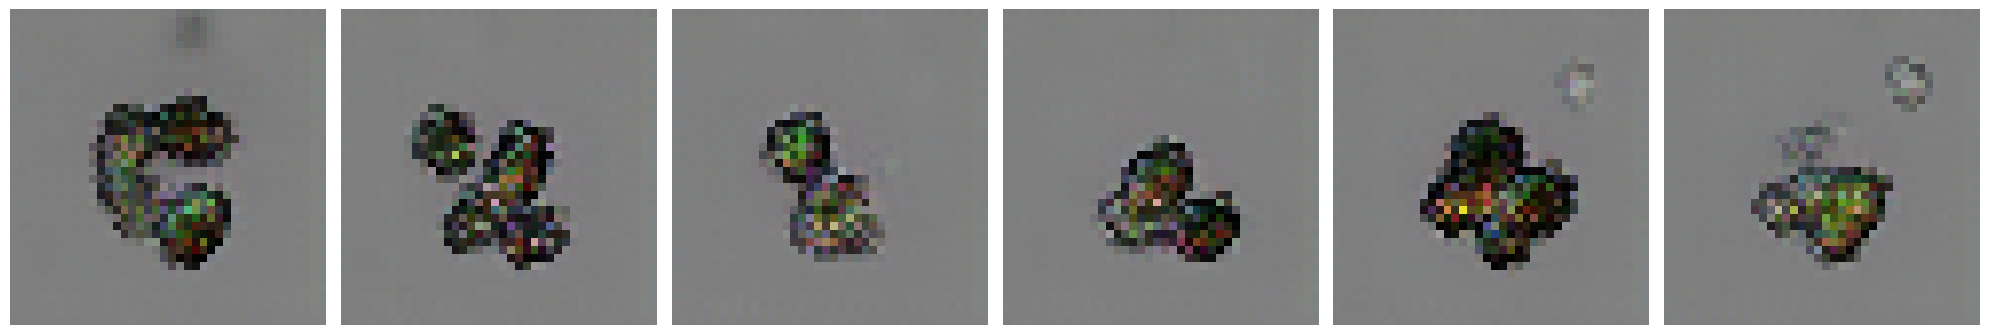

epoch: 50
1/1 [==============================] - 0s 38ms/step


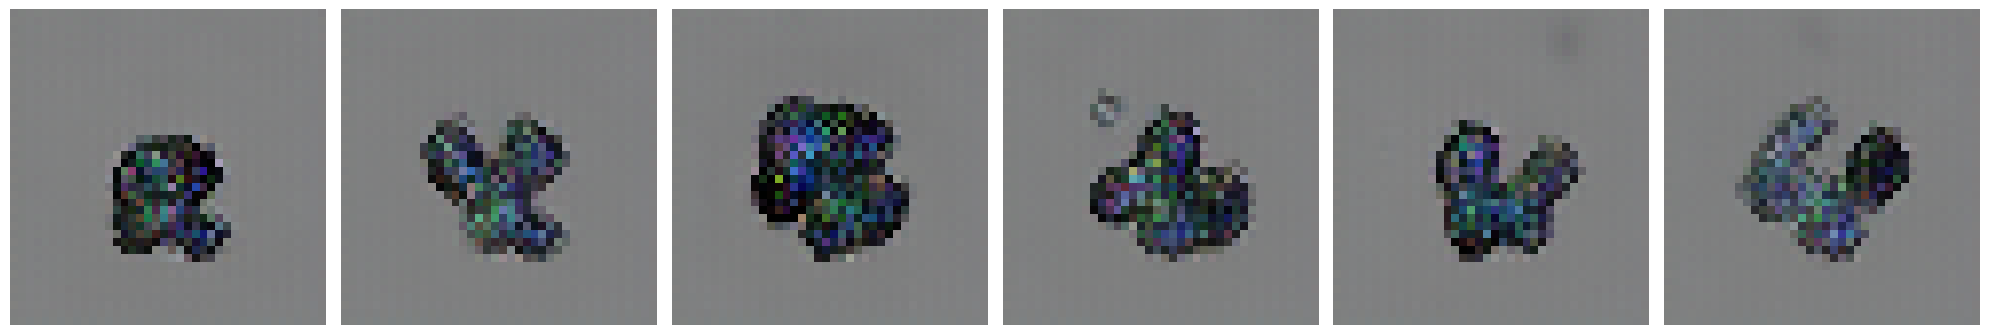

epoch: 60
1/1 [==============================] - 0s 38ms/step


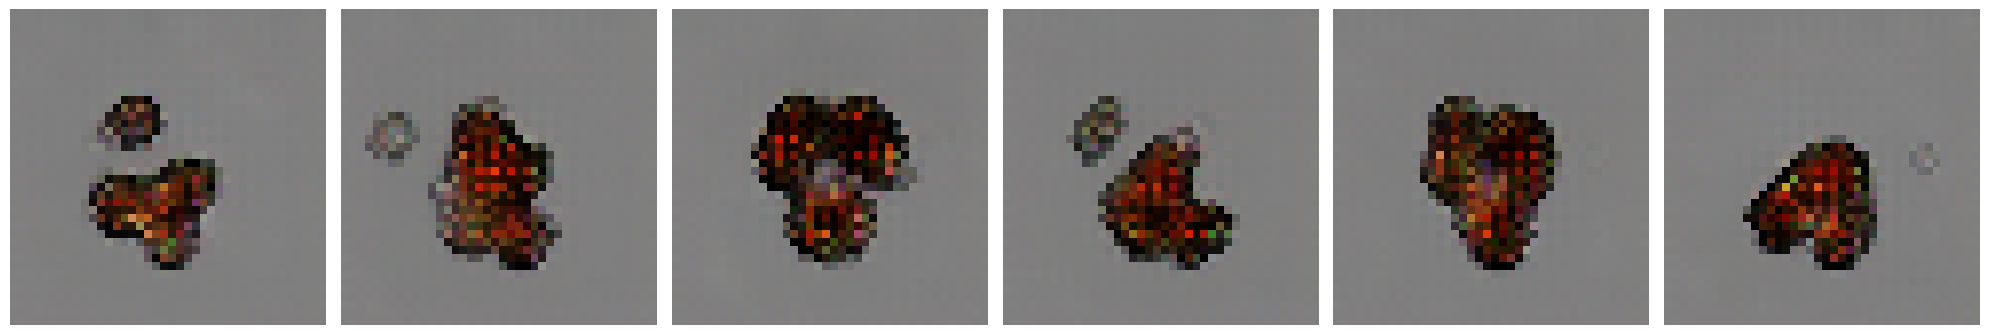

epoch: 70
1/1 [==============================] - 0s 37ms/step


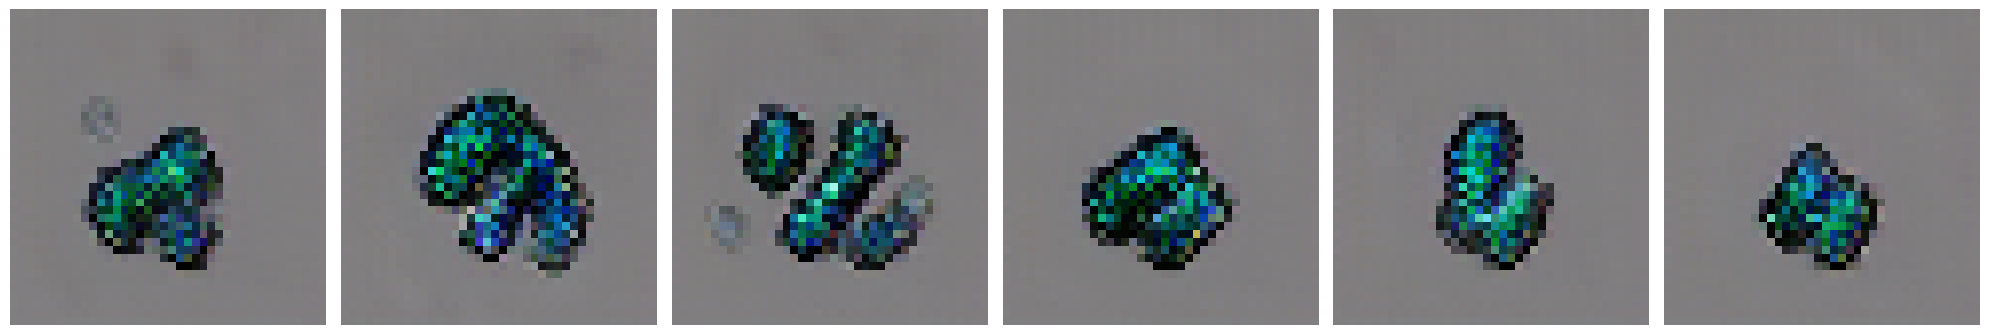

In [ ]:
epochs = 100
train_model(epochs, batch_size)

In [18]:
def load_images():
    x = []
    for i in range(1,711):
        if(i!=201):
            image = io.imread("pokemon\\" + str(i) + ".png")
            image = color.rgba2rgb(image)
            pad = np.full((40,40, 3), (1,1,1), dtype=np.float32)
            x_center = 0
            y_center = (10) // 2
            pad[y_center:y_center+30, x_center:x_center+40] = image
            pad = (pad*2 - 1)
            x.append(pad)
    #x = np.asarray(x).astype(np.float32)
    return x

In [19]:
X_train = load_images()
X_train=np.asarray(X_train)
print(X_train.shape)

(709, 40, 40, 3)


In [20]:
def plot_generated_images(generator):
    num_of_images = 6
    noise = np.random.normal(0, 1.0, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise)
    generated_images = np.asarray((generated_images+1) / 2).astype(np.float32)
    all_images.append(generated_images)
    plt.figure(figsize=(20, 4))
    for i in range(num_of_images):
        plt.subplot(1, 6, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

epoch: 0
1/1 [==============================] - 0s 88ms/step


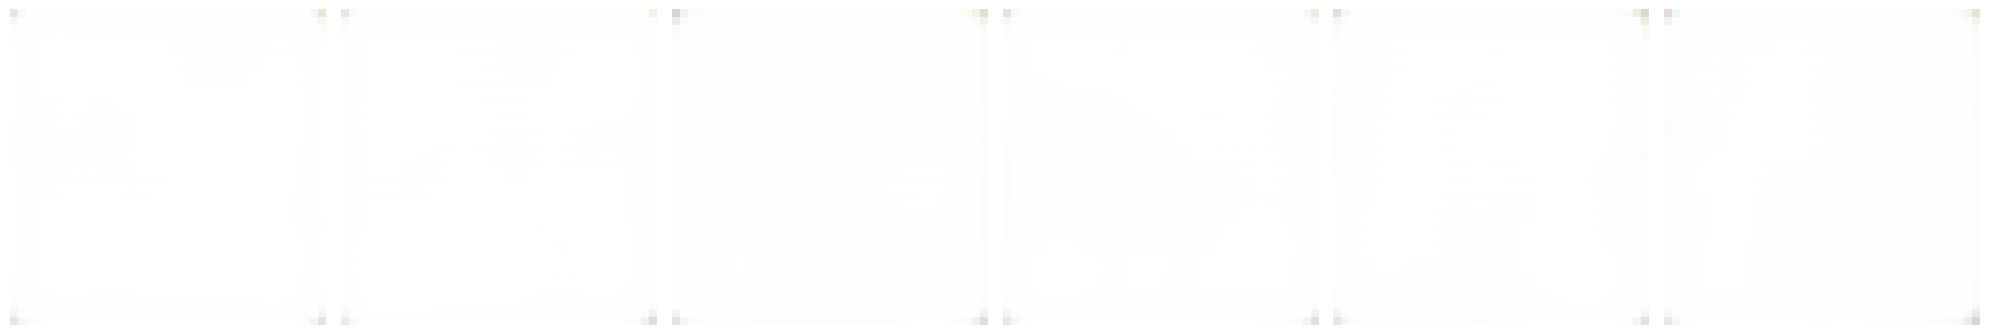

epoch: 10
1/1 [==============================] - 0s 94ms/step


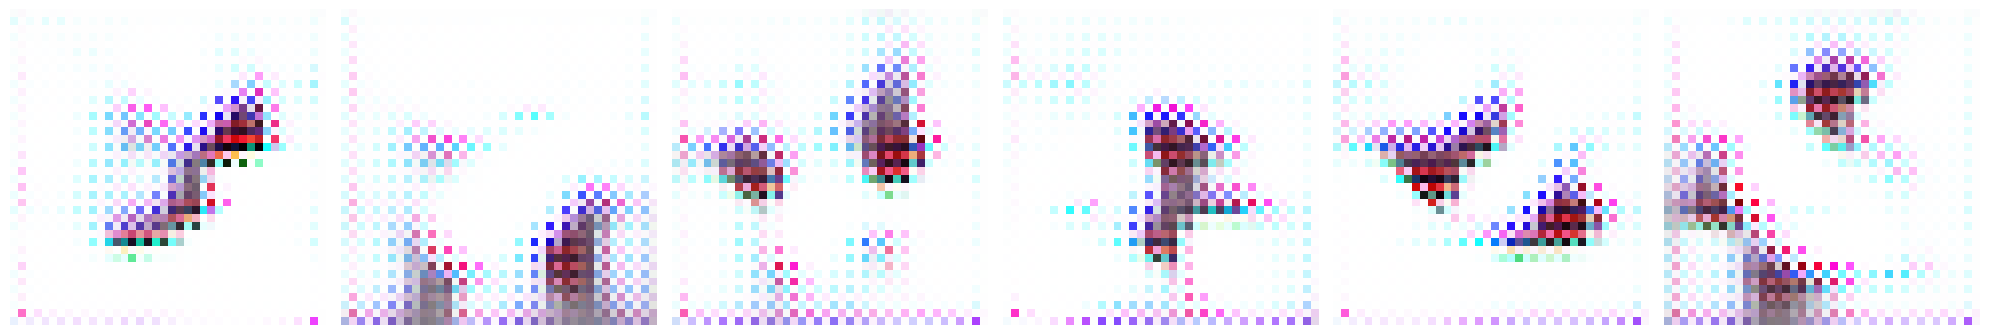

epoch: 20
1/1 [==============================] - 0s 87ms/step


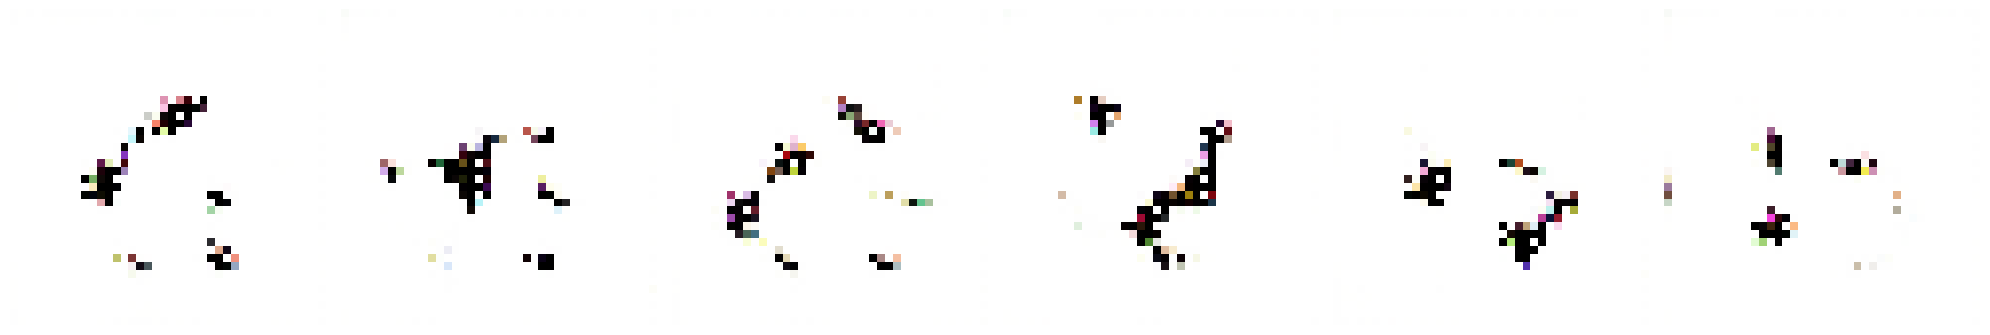

epoch: 30
1/1 [==============================] - 0s 96ms/step


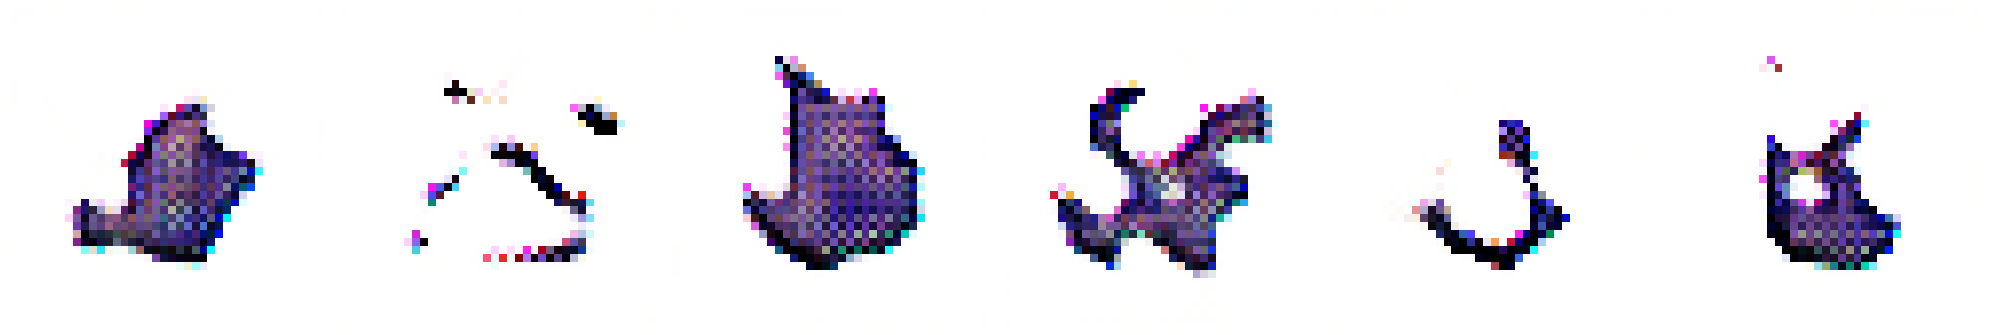

epoch: 40
1/1 [==============================] - 0s 92ms/step


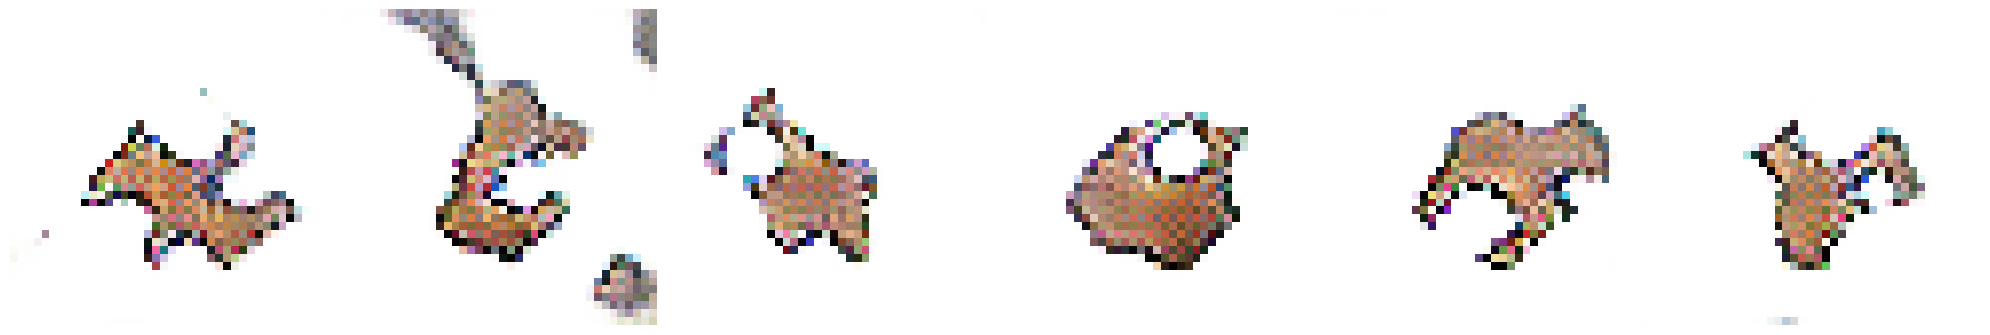

epoch: 50
1/1 [==============================] - 0s 93ms/step


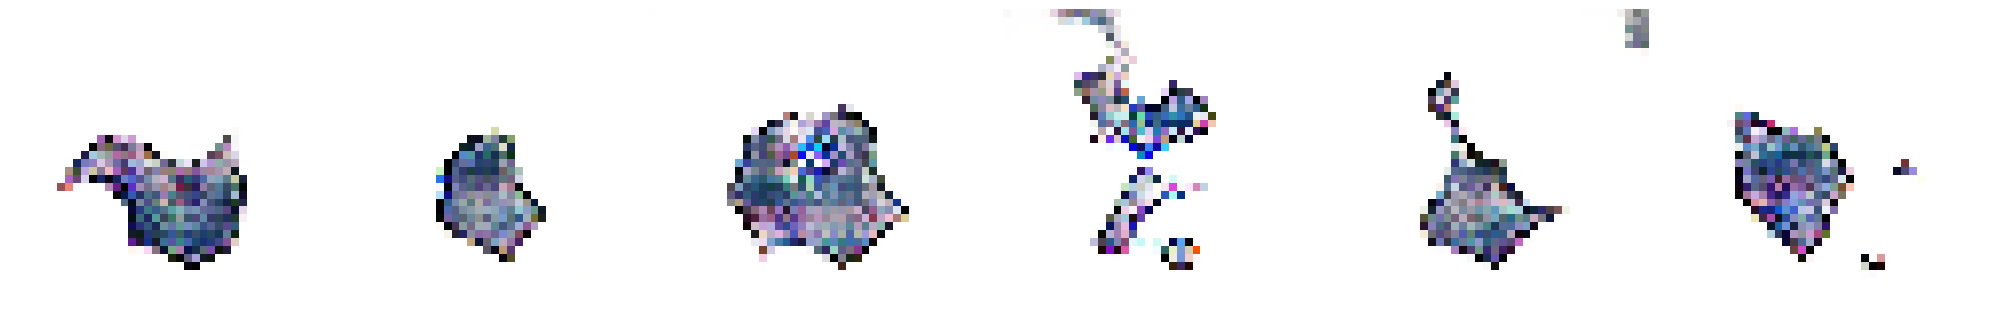

epoch: 60
1/1 [==============================] - 0s 116ms/step


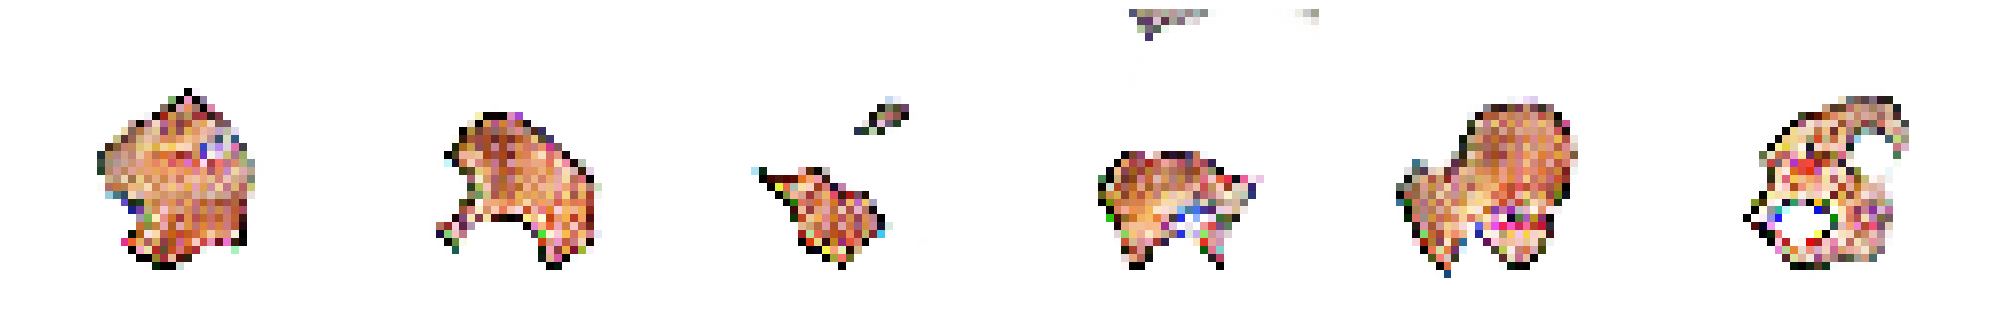

epoch: 70
1/1 [==============================] - 0s 102ms/step


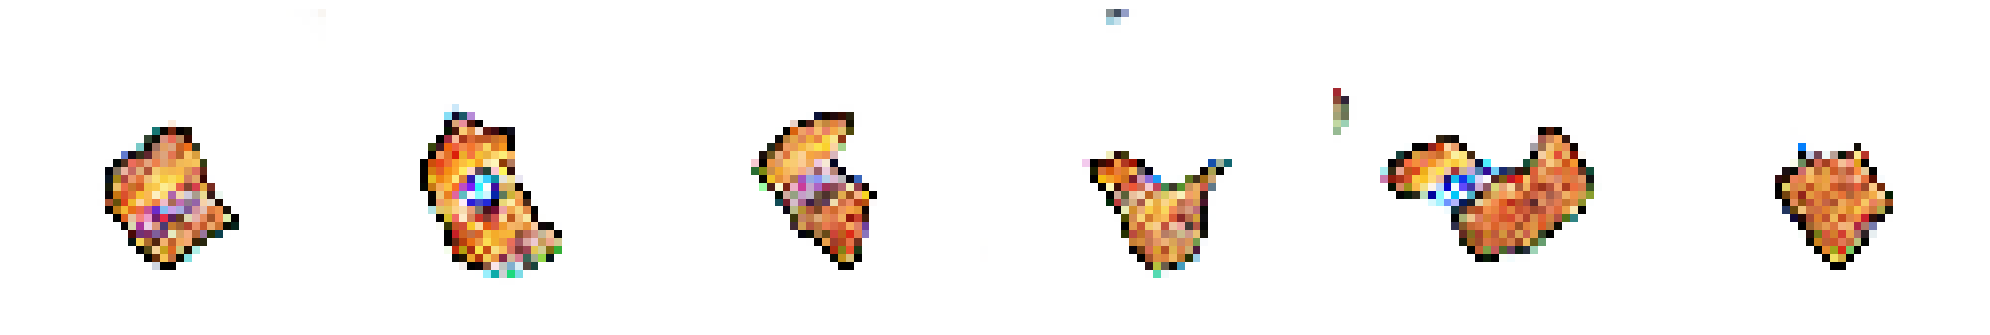

In [22]:
np.random.seed(1)
epochs = 70 
batch_size = 32
train_model(epochs, batch_size)

In [23]:
gan.save_weights("saved_model\\" + 'pokeNmodel')

In [21]:
gan.load_weights("saved_model\\" + 'pokeNmodel')

epoch: 0
1/1 [==============================] - 0s 91ms/step


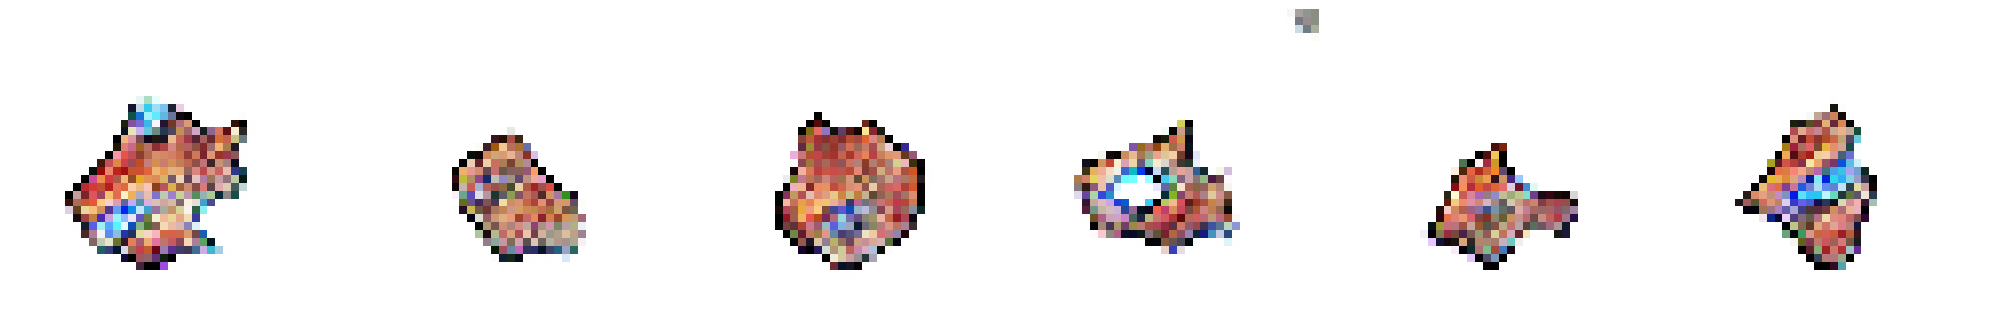

epoch: 10
1/1 [==============================] - 0s 93ms/step


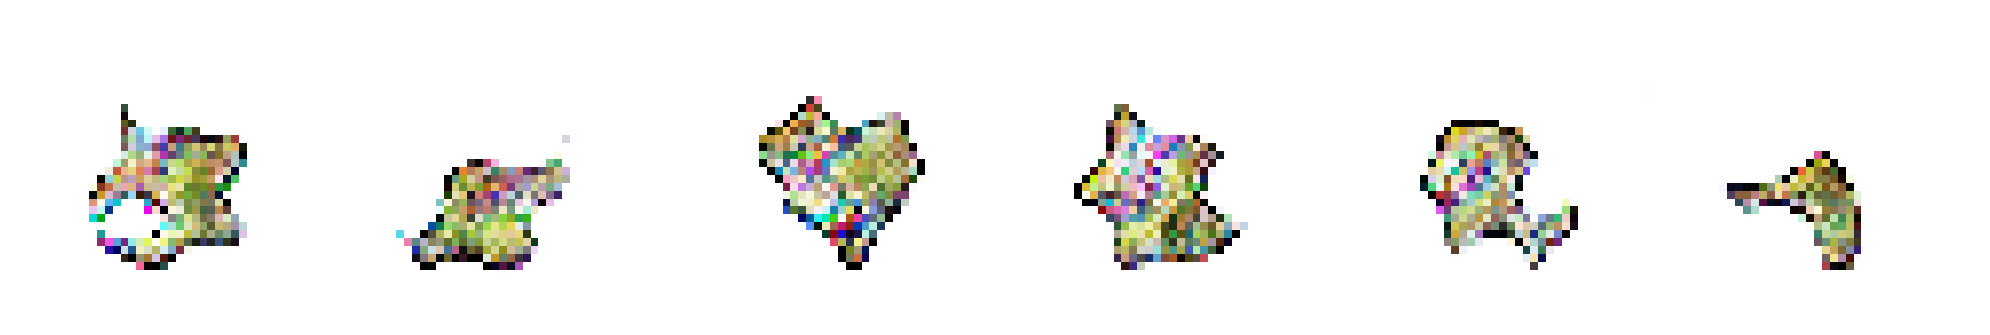

epoch: 20
1/1 [==============================] - 0s 91ms/step


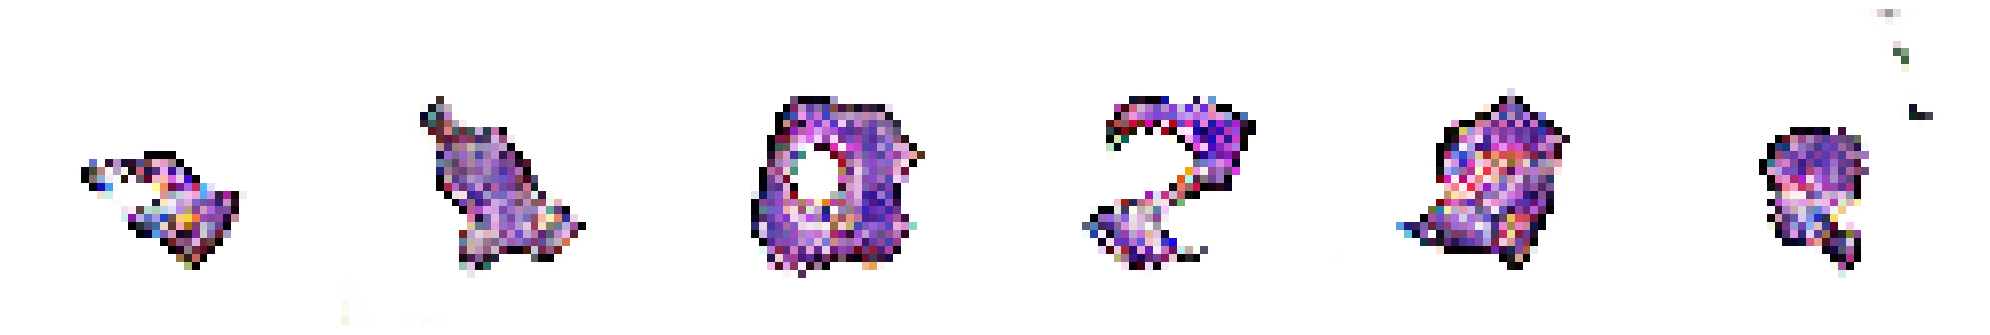

epoch: 30
1/1 [==============================] - 0s 113ms/step


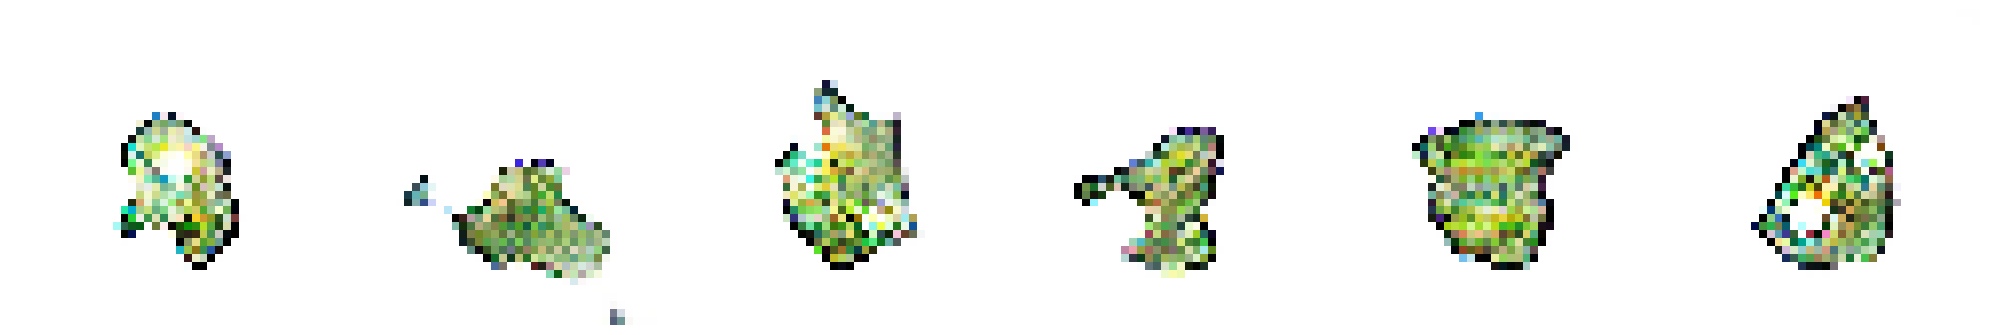

epoch: 40
1/1 [==============================] - 0s 91ms/step


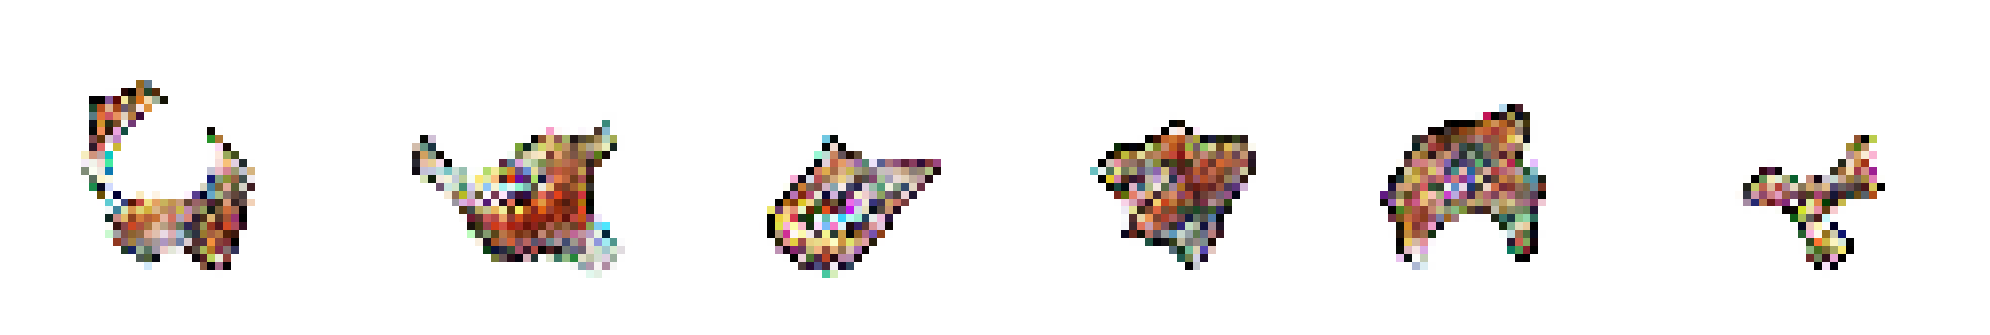

epoch: 50
1/1 [==============================] - 0s 94ms/step


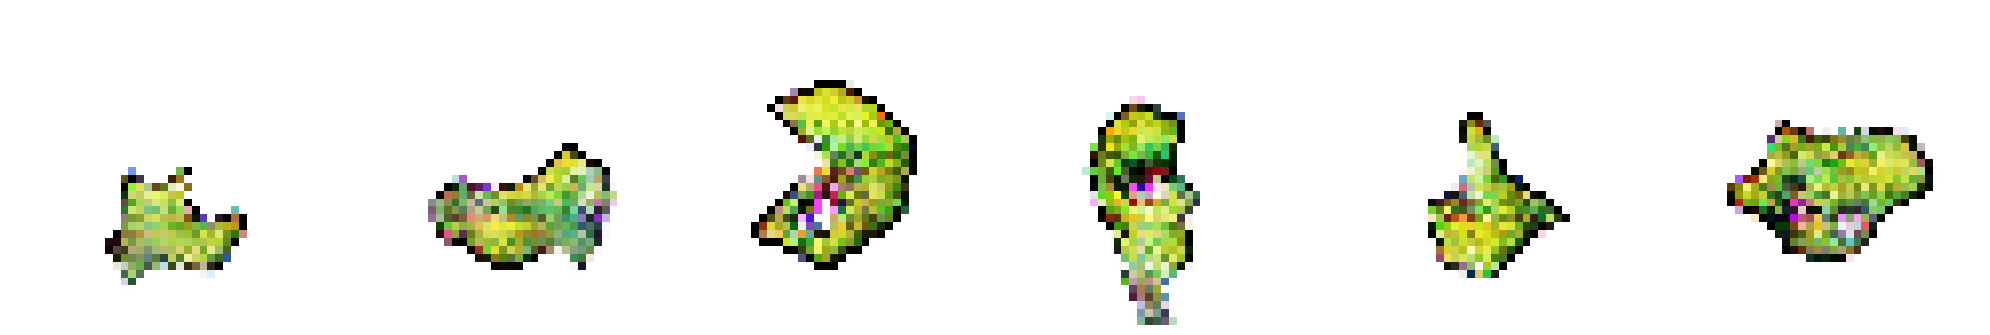

epoch: 60
1/1 [==============================] - 0s 91ms/step


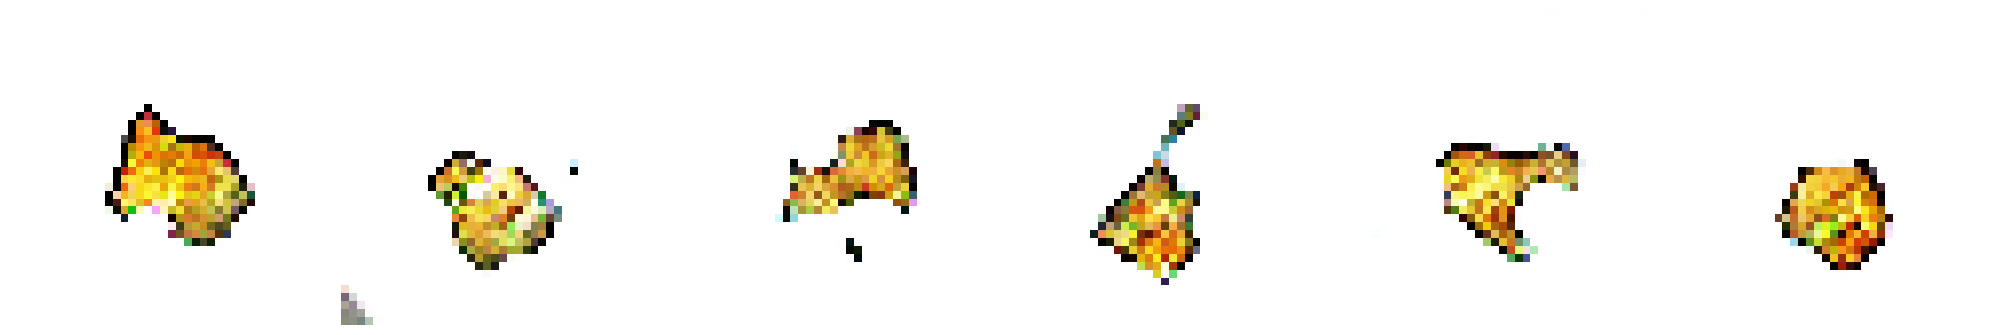

epoch: 70
1/1 [==============================] - 0s 90ms/step


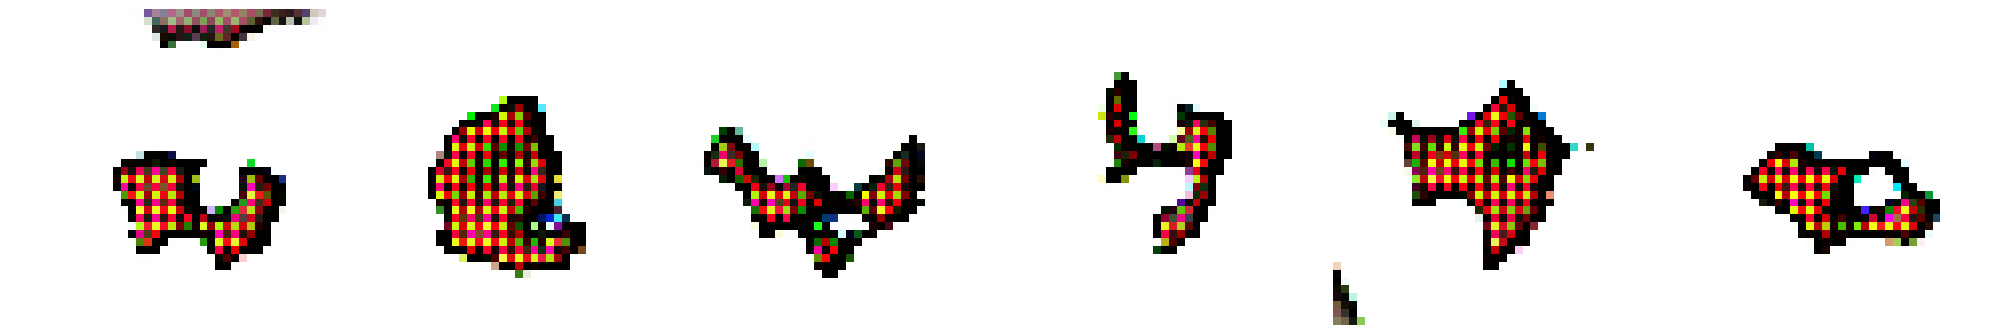

In [24]:
train_model(epochs, batch_size)

In [25]:
gan.save_weights("saved_model\\" + 'pokeN2model')

In [ ]:
gan.load_weights("saved_model\\" + 'pokeN2model')

epoch: 0
1/1 [==============================] - 0s 39ms/step


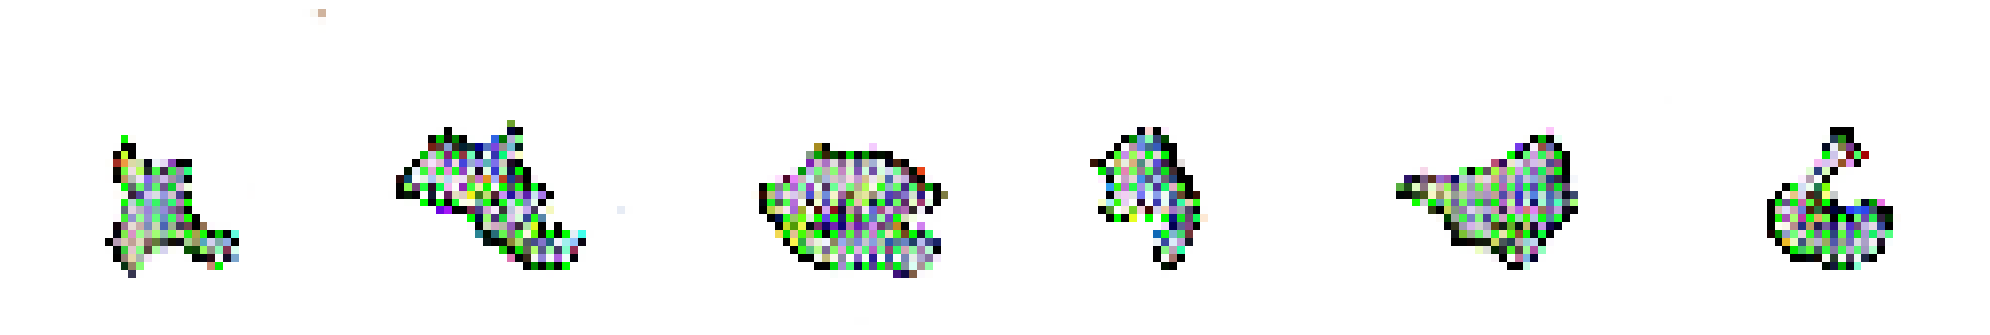

epoch: 10
1/1 [==============================] - 0s 37ms/step


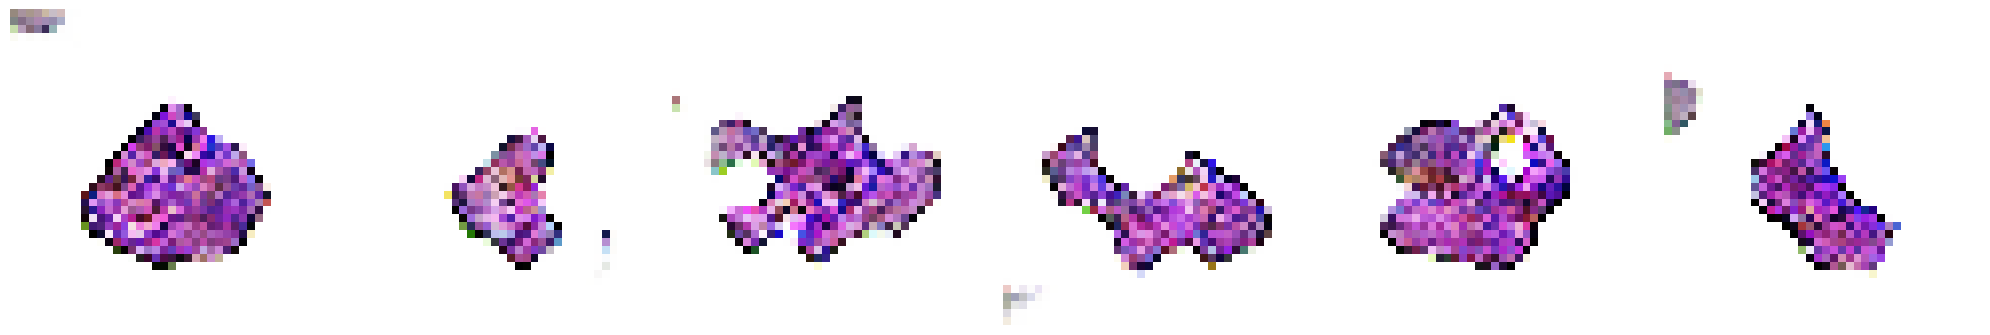

epoch: 20
1/1 [==============================] - 0s 36ms/step


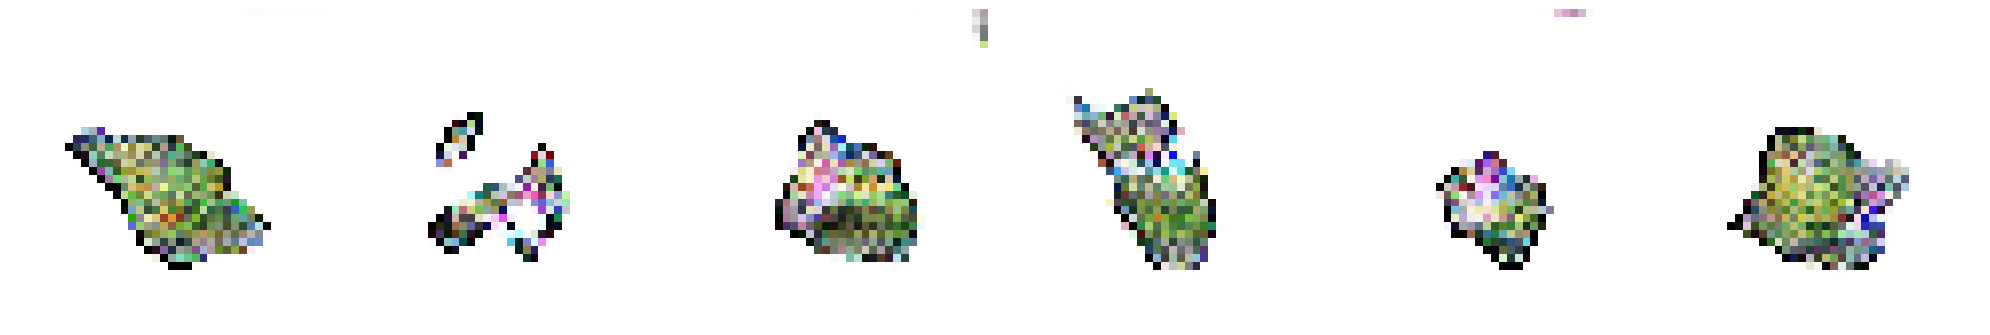

epoch: 30
1/1 [==============================] - 0s 35ms/step


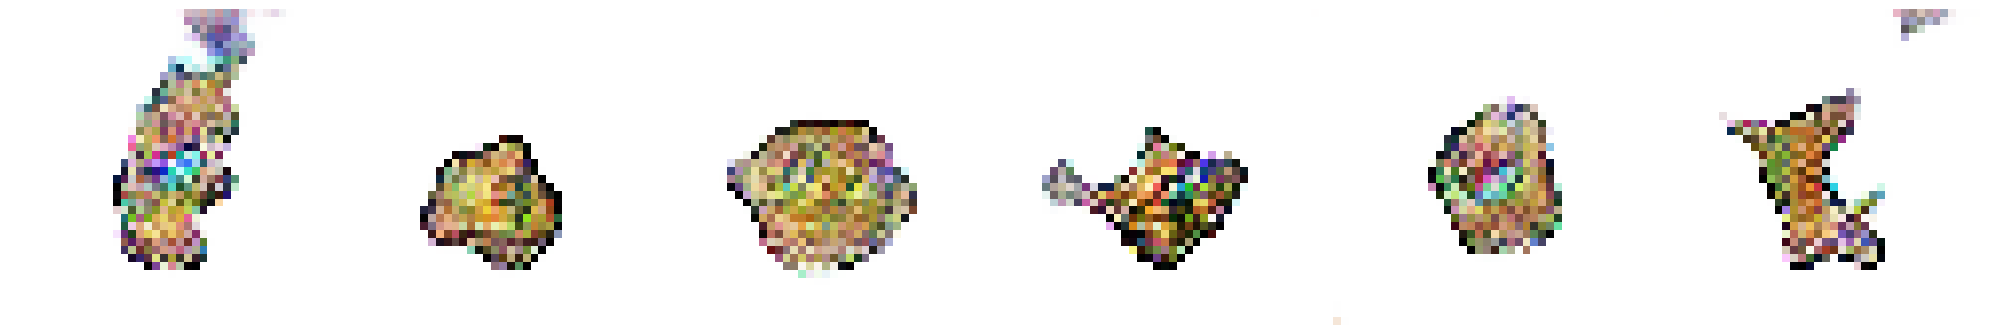

In [27]:
train_model(30, 42)

In [22]:
gan.load_weights("saved_model\\" + 'pokeNmodel')

epoch: 0
1/1 [==============================] - 0s 131ms/step


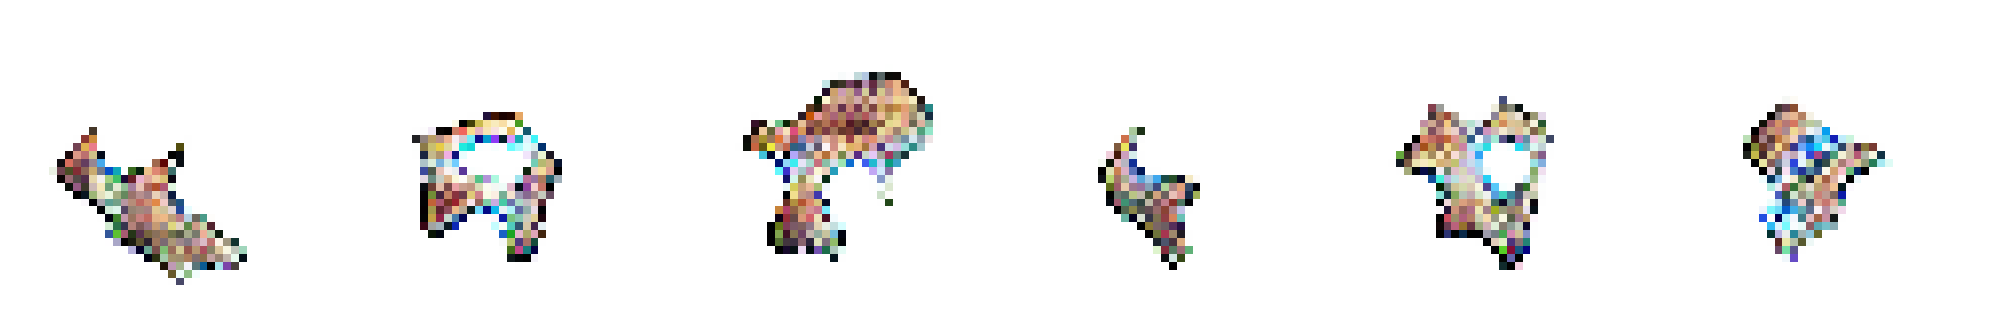

epoch: 10
1/1 [==============================] - 0s 37ms/step


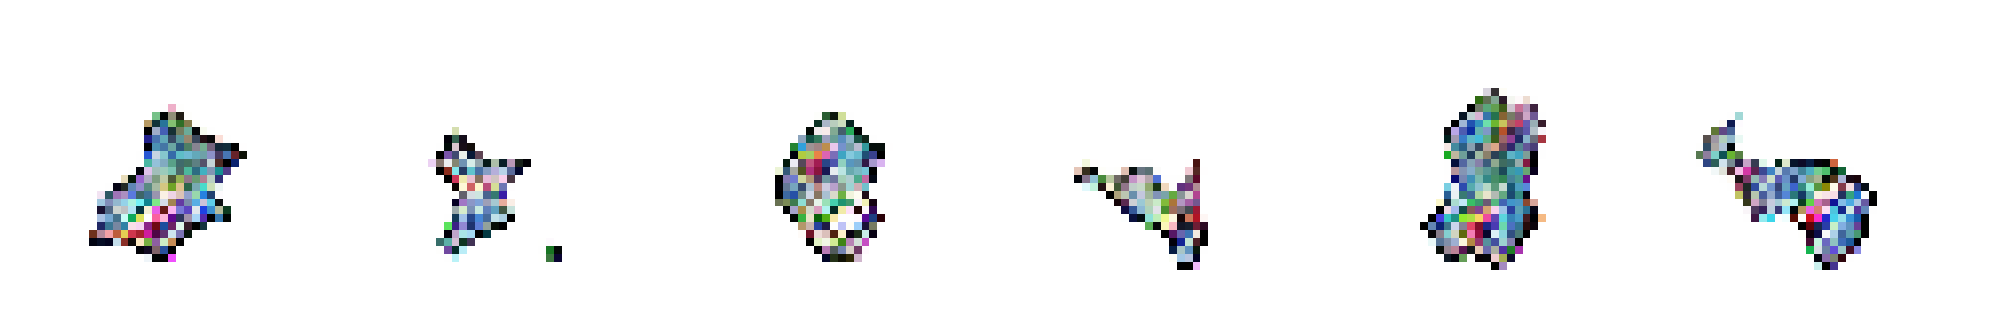

epoch: 20
1/1 [==============================] - 0s 40ms/step


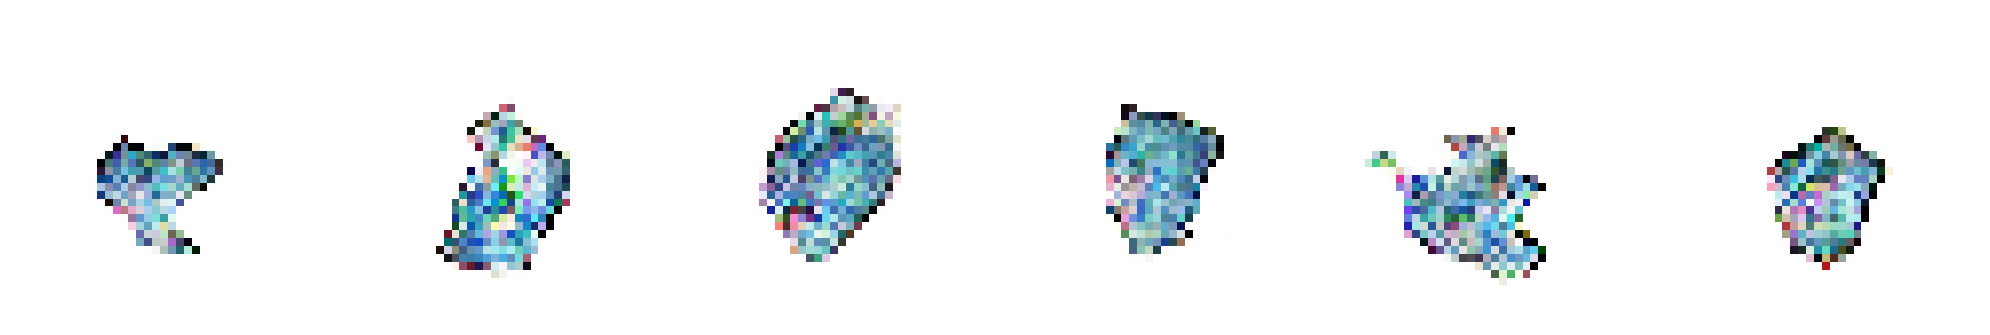

epoch: 30
1/1 [==============================] - 0s 37ms/step


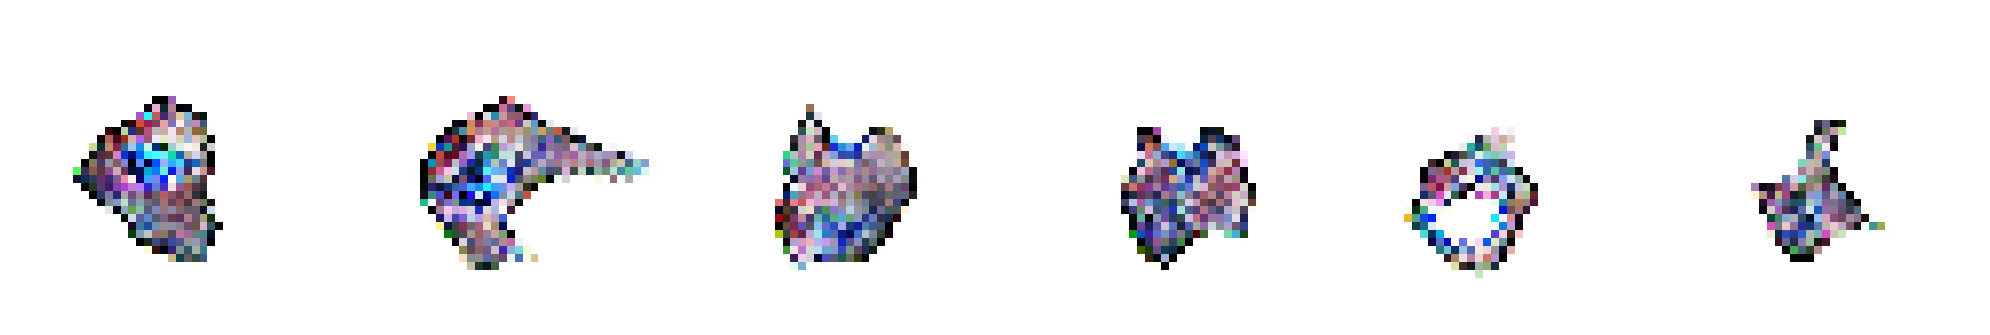

In [23]:
train_model(30, 42)

In [24]:
gan.save_weights("saved_model\\" + 'pokeNmodel')

In [26]:
gan.load_weights("saved_model\\" + 'pokeNmodel')

epoch: 0
1/1 [==============================] - 0s 36ms/step


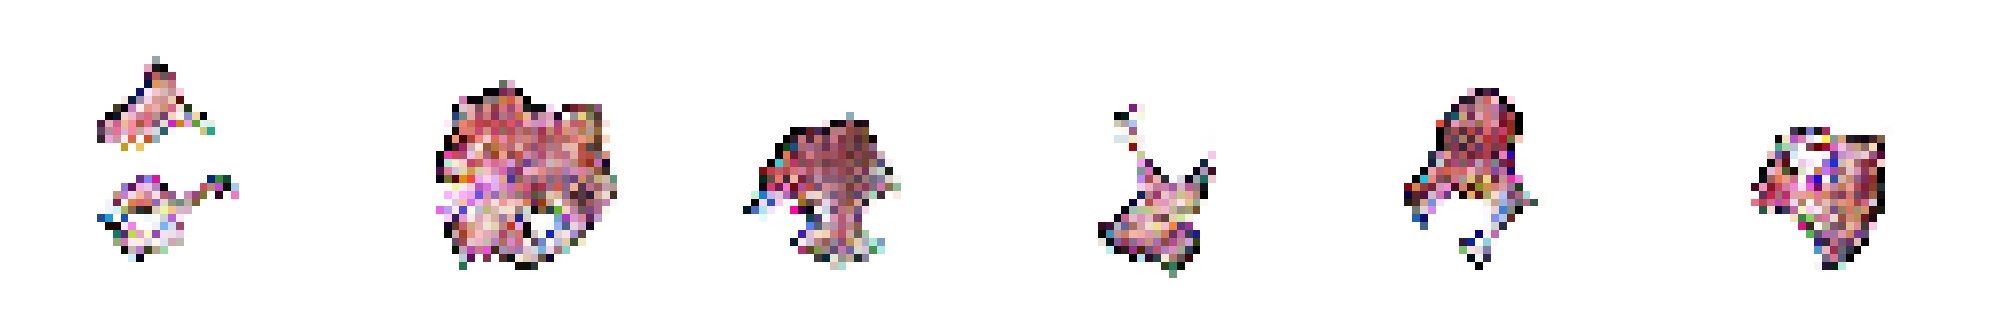

epoch: 10
1/1 [==============================] - 0s 35ms/step


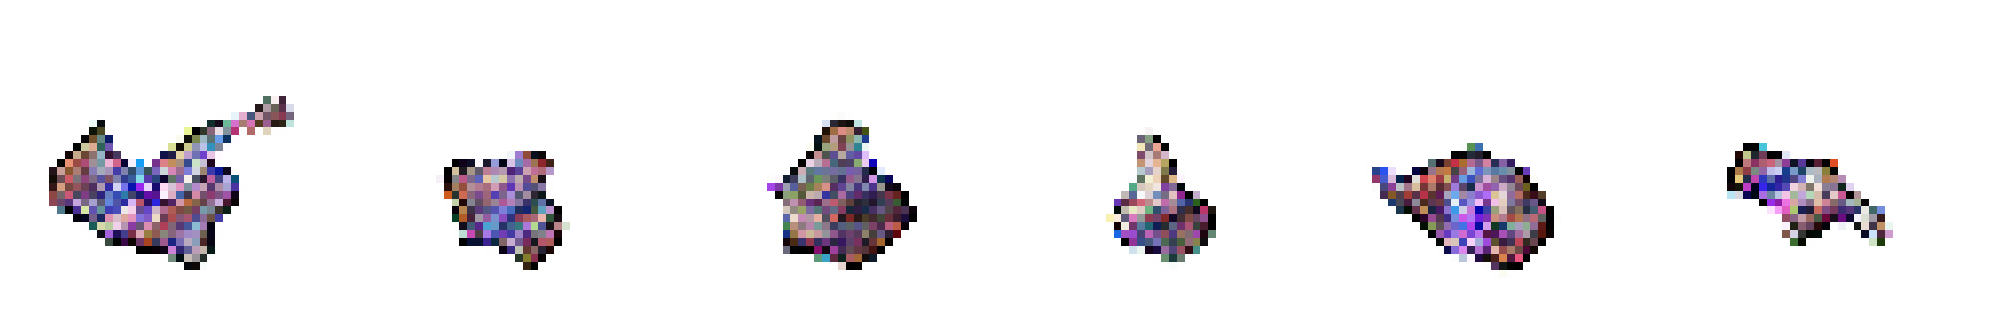

epoch: 20
1/1 [==============================] - 0s 47ms/step


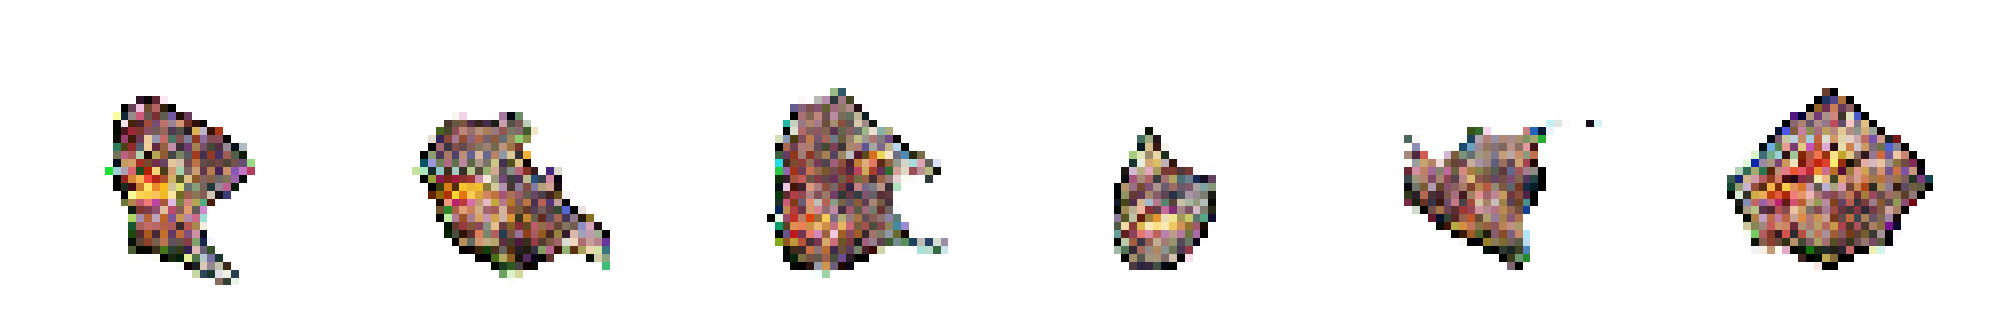

epoch: 30
1/1 [==============================] - 0s 35ms/step


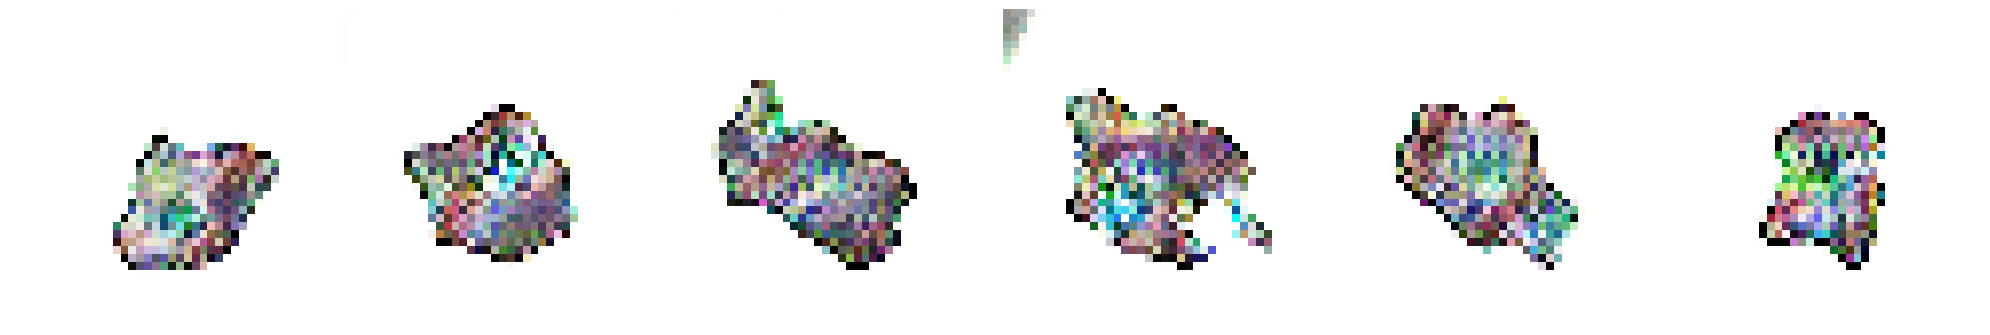

In [27]:
train_model(30, 42)

In [28]:
gan.save_weights("saved_model\\" + 'pokeNmodel')

In [29]:
gan.load_weights("saved_model\\" + 'pokeNmodel')

epoch: 0
1/1 [==============================] - 0s 35ms/step


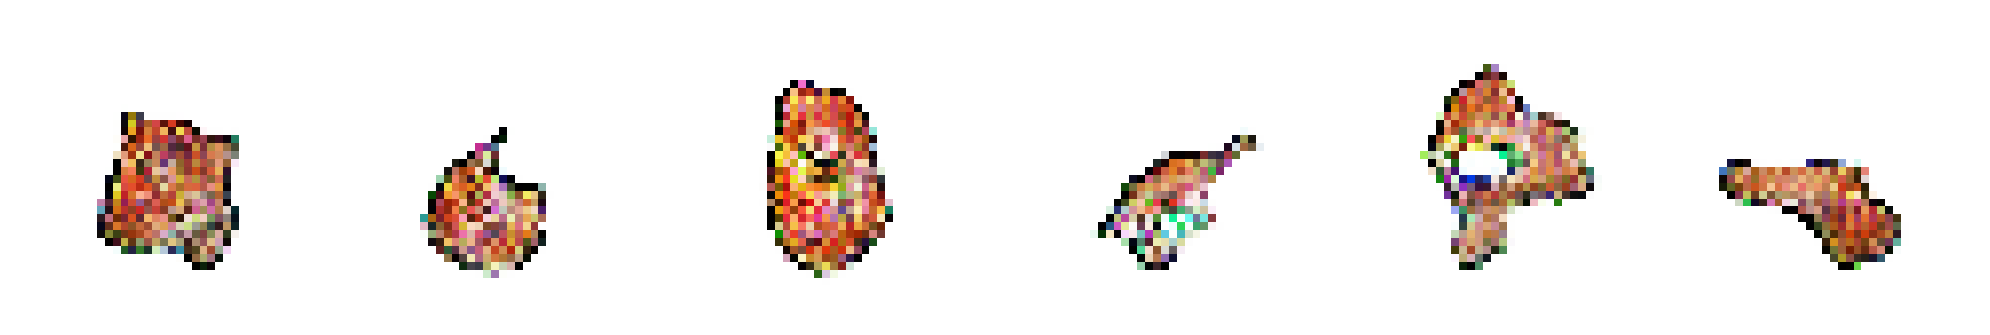

epoch: 10
1/1 [==============================] - 0s 35ms/step


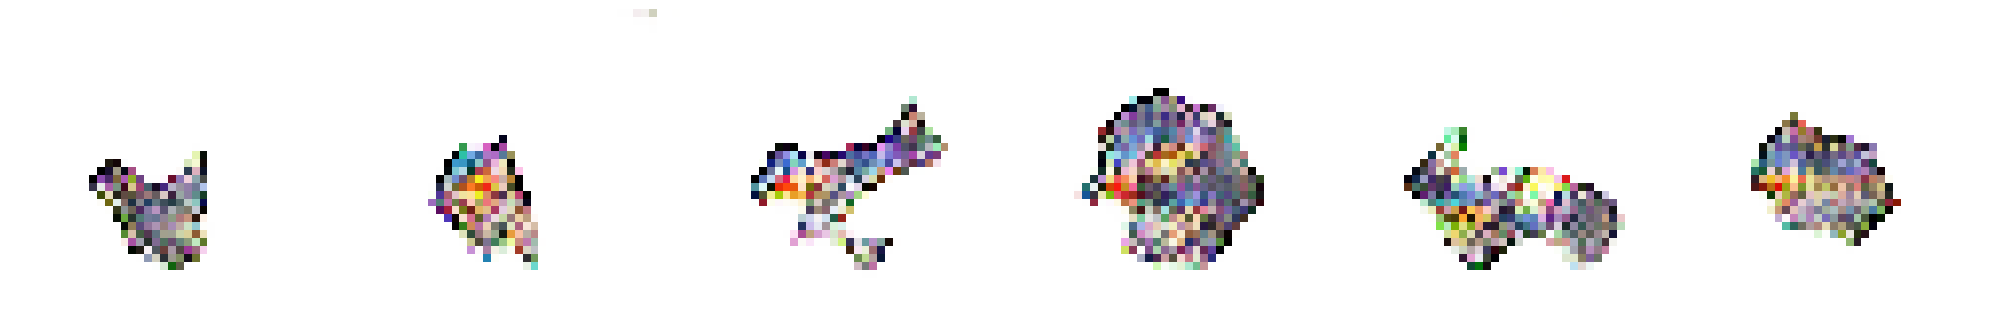

epoch: 20
1/1 [==============================] - 0s 58ms/step


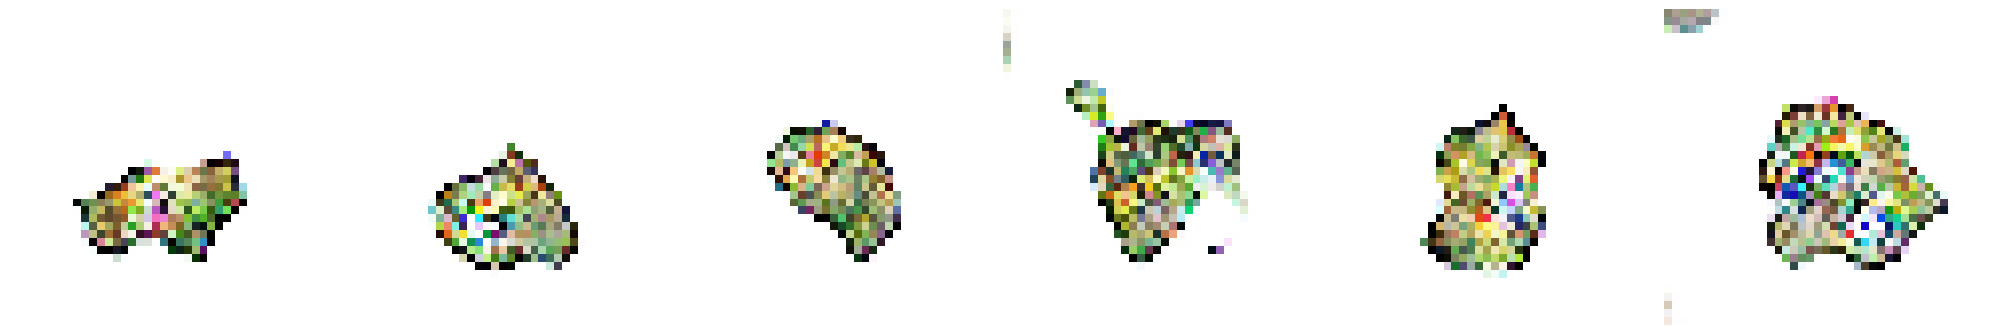

epoch: 30
1/1 [==============================] - 0s 41ms/step


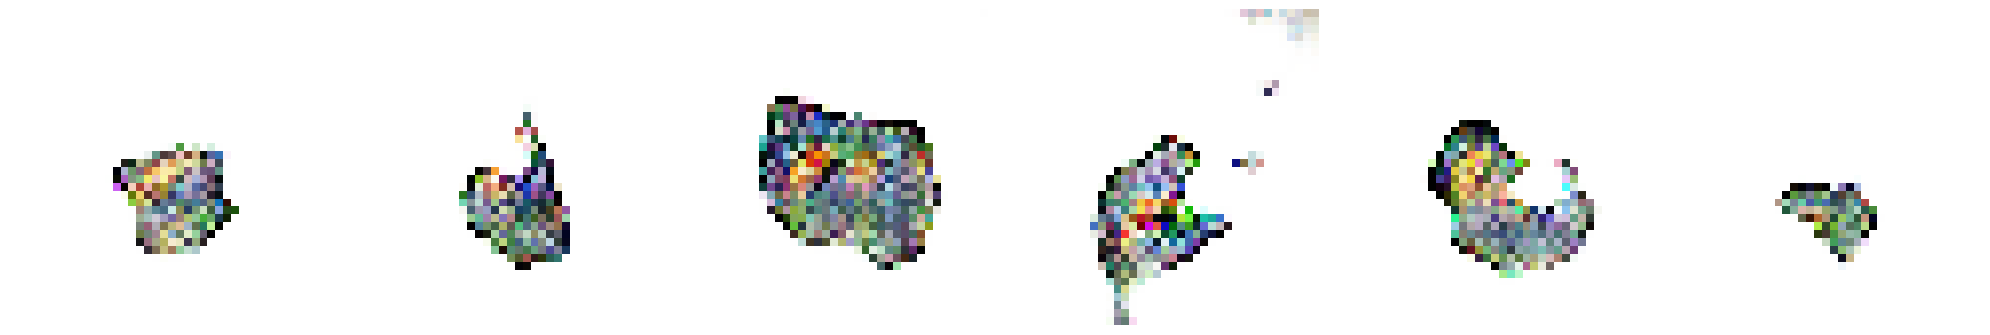

In [30]:
train_model(30, 42)

<font size="7">Hugging face</font>

In [4]:
from transformers import pipeline

<font size="5">POSITIVE/NEGATIVE</font>

In [26]:
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceCla

In [24]:
example_positive = 'Hello there, this is my cake review. Cake is good!'
classifier(example_positive)

[{'label': 'POSITIVE', 'score': 0.9998517036437988}]

In [25]:
example_negative = 'Hello there, this is my cake review. Cake is not good.'
classifier(example_negative)

[{'label': 'NEGATIVE', 'score': 0.9997521042823792}]

In [8]:
example_positive_with_ambiguous_wording = 'I hate how good this cake is!'
classifier(example_positive_with_ambiguous_wording)

[{'label': 'NEGATIVE', 'score': 0.6888824701309204}]

In [27]:
example_positive_with_ambiguous_wording_2 = 'I hate how good this delicious cake is!'
classifier(example_positive_with_ambiguous_wording_2)

[{'label': 'POSITIVE', 'score': 0.9979645013809204}]

In [28]:
example_negative_verbouse = 'Hello, my name is Yevhenii but people call me Ye. Today im going to review this described to be \'delicious\' cake. It is, in fact, not that delicious. It has its charm, but you can not ride on charm alone. In conclusion, i do not like this cake and i am not going to elaborate on that.'
classifier(example_negative_verbouse)

[{'label': 'POSITIVE', 'score': 0.7968795299530029}]

<font size="5"> Text Generation</font>

In [15]:
text_generator = pipeline("text-generation", model = "sshleifer/tiny-gpt2")

Downloading:   0%|          | 0.00/452k [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at sshleifer/tiny-gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [20]:
text_1 = text_generator(
    "Hello. Here is my cake review.",
    max_length = 100,
    num_return_sequences = 1,
)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


In [21]:
print(text_1)

[{'generated_text': 'Hello. Here is my cake review. chromos surveillance Hardware Hardware SATA collections Ramrenchesle Reduce opposekayaucky supplementation specs illustrationrenches Triplecowigl Ramincialetting supplementation ibnCast scaresfoundlandleManchester Triplefoundland supplementationrenchesrenches goods Triple Gerr Gerr Triple 1933 Photoshop SavannahRelated milestone involved Reduce supplementation specsbridkayakaya mobile supplementation vividCastiglfoundlandManchester vividfoundland thickle PhotoshopManchesterbrid goods supplementation supplementationiglPers Ram SATA specsincial Savannah collectionsPersincial 1933Manchester Theodore milestoneigl milestone opposeiglbridfoundland collections milestone Reduce'}, {'generated_text': 'Hello. Here is my cake review. opposeendumcow vividfoundlanduro prison Ram chromos correlated surveillancekayaucky 1999renches oppose goods Gerr illustration chromos ibnPers PhotoshopPers milestone mobilefoundland mobile milestone Photoshop mobil

In [13]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [29]:
model_name = "ProsusAI/finbert"

model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

N:\python_dataset\pythonNeuralNet\venv\lib\site-packages\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [30]:
classifier = pipeline('sentiment-analysis', model = model, tokenizer = tokenizer)

In [31]:
example_positive = 'Hello there, this is my cake review. Cake is good!'
classifier(example_positive)

[{'label': 'neutral', 'score': 0.4100174605846405}]

In [32]:
example_negative = 'Hello there, this is my cake review. Cake is not good.'
classifier(example_negative)

[{'label': 'negative', 'score': 0.4805509150028229}]

In [33]:
example_positive_with_ambiguous_wording = 'I hate how good this cake is!'
classifier(example_positive_with_ambiguous_wording)

[{'label': 'negative', 'score': 0.4367159605026245}]

In [34]:
example_negative_verbouse = 'Hello, my name is Yevhenii but people call me Ye. Today im going to review this described to be \'delicious\' cake. It is, in fact, not that delicious. It has its charm, but you can not ride on charm alone. In conclusion, i do not like this cake and i am not going to elaborate on that.'
classifier(example_negative_verbouse )

[{'label': 'negative', 'score': 0.35597872734069824}]

In [35]:
inputs = tokenizer([example_positive, example_negative])
inputs

{'input_ids': [[101, 7592, 2045, 1010, 2023, 2003, 2026, 9850, 3319, 1012, 9850, 2003, 2204, 999, 102], [101, 7592, 2045, 1010, 2023, 2003, 2026, 9850, 3319, 1012, 9850, 2003, 2025, 2204, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [36]:
tokens = tokenizer.tokenize(example_positive)
tokens

['hello',
 'there',
 ',',
 'this',
 'is',
 'my',
 'cake',
 'review',
 '.',
 'cake',
 'is',
 'good',
 '!']

In [38]:
print(tokenizer.convert_tokens_to_ids(tokens))
print(tokenizer.decode(tokenizer.convert_tokens_to_ids(tokens)))

[7592, 2045, 1010, 2023, 2003, 2026, 9850, 3319, 1012, 9850, 2003, 2204, 999]
hello there, this is my cake review. cake is good!


ua-eng data: https://www.manythings.org/anki/

Conv GAN partially based on https://github.com/natsakh/Data-Analysis/blob/main/Pr_9/9.2%20DCGAN%20CIFAR-10.ipynb

Translator heavily based on https://www.tensorflow.org/text/tutorials/nmt_with_attention

Pokemon image dataset https://www.kaggle.com/datasets/truthisneverlinear/pokemon-generations-image-dataset